## IMPORTS AND LOADING

#### IMPORTS & FUNCTIONS

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [214]:
def split_data(data: pd.DataFrame, target_name: str, frac_test: float,
               seed: int) -> tuple[pd.DataFrame, np.ndarray, pd.DataFrame, np.ndarray]:
  X = data.drop(target_name, axis=1)
  y = data[target_name]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=frac_test,
                                                      random_state=seed)
  X_train = X_train.reset_index(drop = True)
  X_test = X_test.reset_index(drop = True)
  y_train = y_train.values
  y_test = y_test.values
  return X_train, y_train, X_test, y_test

def add_baseline(y_train, y_test) -> dict:
  return {'model': 'baseline',
          'mse train': np.round(mean_squared_error(y_train, np.full(len(y_train), np.mean(y_train))), 3),
          'mse test': np.round(mean_squared_error(y_test, np.full(len(y_test), np.mean(y_train))), 3),
          'number of features': 0}

def add_model(name: str, model: object, x_train: pd.DataFrame, y_train: np.ndarray,
              x_test: pd.DataFrame, y_test: np.ndarray) -> dict:
  return {'model': name,
          'mse train': np.round(mean_squared_error(y_train, model.predict(x_train)), 3),
          'mse test': np.round(mean_squared_error(y_test, model.predict(x_test)), 3),
          'number of features': x_test.shape[1]}

In [215]:
def tab_value_counts(columns: tuple, data : pd.DataFrame) -> pd.DataFrame:

    df = pd.DataFrame(columns=['feature','value','count','relative_proportion'])
    value_counts_df = pd.DataFrame()

    for column in columns:
        value_counts = data[column].value_counts().reset_index()
        value_counts.columns = ['value','count']
        value_counts['feature'] = column
        value_counts_relative = data[column].value_counts(normalize=True).reset_index().round(3)
        value_counts_relative.columns = ['value','relative proportion']
        value_counts = value_counts.merge(value_counts_relative, on='value')
        value_counts = value_counts[['feature', 'value', 'count','relative proportion']]
        value_counts_df = pd.concat([value_counts_df, value_counts], ignore_index=True)

    return value_counts_df

#### LOADING THE DATASET


In [11]:
ORIGINAL_DF = pd.read_csv('Listings.csv',encoding='ISO-8859-1')

C:\Users\Koral\AppData\Local\Temp\ipykernel_16744\2609187546.py:1: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  ORIGINAL_DF = pd.read_csv('Listings.csv',encoding='ISO-8859-1')


In [217]:
#@title DICT FEATURES

FEATURES = {
      'listing_id': ['Listing ID', 'int64'],
      'name': ['Listing Name', 'object'],
      'host_id': ['Host ID', 'int64'],
      'host_since': ['Date the Host joined Airbnb', 'object'],
      'host_location': ['Location where the Host is based', 'object'],
      'host_response_time': ['Estimate of how long the Host takes to respond', 'object'],
      'host_response_rate': ['Percentage of times the Host responds', 'float64'],
      'host_acceptance_rate': ['Percentage of times the Host accepts a booking request', 'float64'],
      'host_is_superhost': ['Binary field to determine if the Host is a Superhost', 'object'],
      'host_total_listings_count': ['Total listings the Host has in Airbnb', 'float64'],
      'host_has_profile_pic': ['Binary field to determine if the Host has a profile picture', 'object'],
      'host_identity_verified': ['Binary field to determine if the Host has a verified identity', 'object'],
      'neighbourhood': ['Neighborhood the Listing is in', 'object'],
      'district': ['District the Listing is in', 'object'],
      'city': ['City the Listing is in', 'object'],
      'latitude': ["Listing's latitude", 'float64'],
      'longitude': ["Listing's longitude", 'float64'],
      'property_type': ['Type of property for the Listing', 'object'],
      'room_type': ['Type of room type in Airbnb for the Listing', 'object'],
      'accommodates': ['Guests the Listing accommodates', 'int64'],
      'bedrooms': ['Bedrooms in the Listing', 'float64'],
      'amenities': ['Amenities the Listing includes', 'object'],
      'price': ['Listing price (in each country\'s currency)', 'int64'],
      'minimum_nights': ['Minimum nights per booking', 'int64'],
      'maximum_nights': ['Maximum nights per booking', 'int64'],
      'review_scores_rating': ["Listing's overall rating (out of 100)", 'float64'],
      'review_scores_accuracy': ["Listing's accuracy score based on what's promoted in Airbnb (out of 10)", 'float64'],
      'review_scores_cleanliness': ["Listing's cleanliness score (out of 10)", 'float64'],
      'review_scores_checkin': ["Listing's check-in experience score (out of 10)", 'float64'],
      'review_scores_communication': ["Listing's communication with the Host score (out of 10)", 'float64'],
      'review_scores_location': ["Listing's location score within the city (out of 10)", 'float64'],
      'review_scores_value': ["Listing's value score relative to its price (out of 10)", 'float64'],
      'instant_bookable': ['Binary field to determine if the Listing can be booked instantly', 'object']
}

FEATURES = pd.DataFrame.from_dict(FEATURES, orient='index', columns = ['Description', 'Data Type']).reset_index().rename(columns = {'index': 'Feature'})

FEATURES_TO_DETECT_ERRORS = ['host_response_rate','host_acceptance_rate','host_total_listings_count','accommodates','bedrooms','minimum_nights','maximum_nights','price']

## DATASET PREPARATION

### BEGIN BY CHECKING HOW THE DATA LOOKS LIKE

In [13]:
ORIGINAL_DF.shape

(279712, 33)

In [219]:
ORIGINAL_DF.drop_duplicates().shape # NO duplicate entries within our dataset's listings

(279712, 33)

In [220]:
FEATURES # Let's gain a better understanding of the features present within the dataset!

,Feature,Description,Data Type
0,listing_id,Listing ID,int64
1,name,Listing Name,object
2,host_id,Host ID,int64
3,host_since,Date the Host joined Airbnb,object
4,host_location,Location where the Host is based,object
5,host_response_time,Estimate of how long the Host takes to respond,object
6,host_response_rate,Percentage of times the Host responds,float64
7,host_acceptance_rate,Percentage of times the Host accepts a booking...,float64
8,host_is_superhost,Binary field to determine if the Host is a Sup...,object
9,host_total_listings_count,Total listings the Host has in Airbnb,float64


Probable that we won't be utilizing certain features ("listing_id" "name" "host_id" "host_location" "latitude" "longitude") in the following algorithmic steps. For now some of these attributes could provide us with insights into the data.

In [221]:
ORIGINAL_DF.sample(5) # Let's inspect the observations

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,...,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable
202503,894042,Fairlight Villa,4757350,2013-01-18,"Sydney, New South Wales, Australia",within an hour,1.0,1.00,f,2.0,...,7,100,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t
222779,44132492,ÃÂ´ÃâÃÂ© ÃÂ³ÃÅ ÃÂ§ÃÂ­ÃÅ ÃÂ© ÃÂ¨Ãâ...,353418358,2020-07-04,TR,within a few hours,0.7,0.43,f,8.0,...,1,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f
70298,5333241,BeyazitHan Suit in Old Town 4,26618301,2015-01-24,"Waipahu, Hawaii, United States",within an hour,1.0,1.00,f,9.0,...,1,1125,95.0,9.0,10.0,10.0,9.0,10.0,10.0,t
71805,31842505,Ponte S.Angelo & P.zza Navona - Perfect Flat x3!,96122546,2016-09-21,IT,within an hour,1.0,1.00,f,354.0,...,2,1125,88.0,9.0,9.0,10.0,10.0,10.0,9.0,t
272647,31298980,Studio cosy quartier Louvre - Les Halles,14798257,2014-04-27,"Paris, Ile-de-France, France",NaN,NaN,1.00,f,1.0,...,3,30,90.0,9.0,10.0,10.0,10.0,10.0,9.0,t


Features exhibit a diverse range of scales due to the inclusion of discrete values (e.g. reviews) and continuous values as well as the incorporation of percentages (host-related attributes) alongside whole numbers.

**These varying scales is a crucial consideration as we proceed with the subsequent algorithmic steps to ensure meaningful results.**

### MISSING VALUES

upon direct inspection of the observations we detected the presence of missing values. In order to derive valuable insights as we continue with EDA our immediate priority is to handle these missing values.

In [222]:
ORIGINAL_DF.isna().sum() # Let's start with an assessment to determine what the extent of missing values present in the data set

listing_id                          0
name                              173
host_id                             0
host_since                        165
host_location                     840
host_response_time             128782
host_response_rate             128782
host_acceptance_rate           113087
host_is_superhost                 165
host_total_listings_count         165
host_has_profile_pic              165
host_identity_verified            165
neighbourhood                       0
district                       242700
city                                0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bedrooms                        29435
amenities                           0
price                               0
minimum_nights                      0
maximum_nights                      0
review_scores_rating            91405
review_score

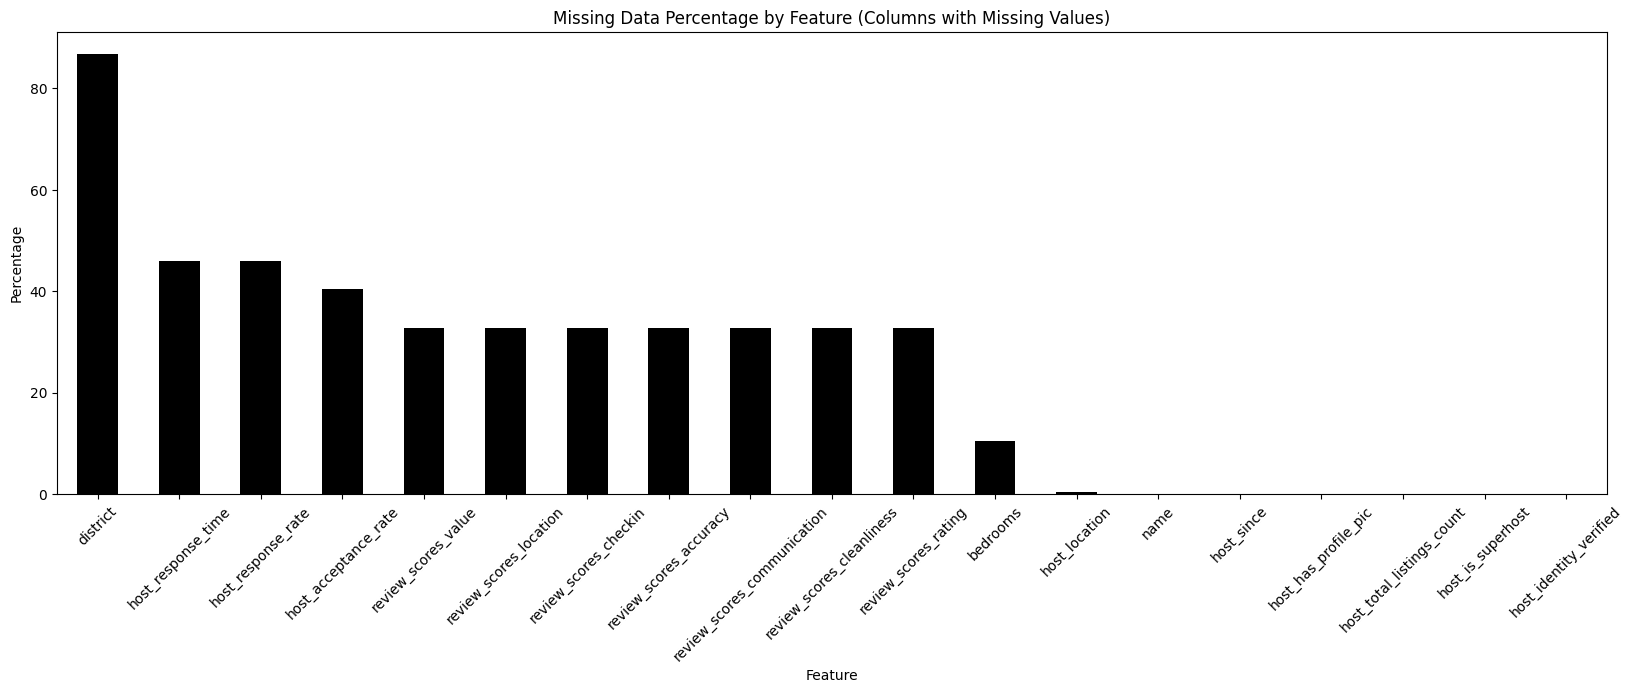

In [223]:
#@title MISSING VALS

missing_percentage = ORIGINAL_DF.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0]  # Filter out columns with 0% missing values

sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

plt.figure(figsize=(20, 6))
sorted_missing_percentage.plot(kind='bar', color='black')
plt.title('Missing Data Percentage by Feature (Columns with Missing Values)')
plt.ylabel('Percentage')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.show()

There are a huge number of missing values (above 80%) for district. Let's see why that is:

In [224]:
print("cities {} districts {}".format(tuple(ORIGINAL_DF['city'].unique()), tuple(ORIGINAL_DF['district'].unique())))

cities ('Paris', 'New York', 'Bangkok', 'Rio de Janeiro', 'Sydney', 'Istanbul', 'Rome', 'Hong Kong', 'Mexico City', 'Cape Town') districts (nan, 'Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island')


This attribute is specific to New York. Given its limited informative value we'll eliminate it.

In [225]:
#@title MISSING VALS

ORIGINAL_DF = ORIGINAL_DF.drop(columns='district')

In [226]:
ORIGINAL_DF.loc[ORIGINAL_DF[['host_response_time','host_response_rate']].isna().any(axis=1)].isna().sum() # missing values according the features are missing 128782 entries

listing_id                          0
name                              164
host_id                             0
host_since                        165
host_location                     571
host_response_time             128782
host_response_rate             128782
host_acceptance_rate            97169
host_is_superhost                 165
host_total_listings_count         165
host_has_profile_pic              165
host_identity_verified            165
neighbourhood                       0
city                                0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bedrooms                        14955
amenities                           0
price                               0
minimum_nights                      0
maximum_nights                      0
review_scores_rating            51559
review_scores_accuracy          51689
review_score

We observe that the features are missing the same number of values (128782 165) are the same data points and it turns out that quite a lot of them have missing values in other features!

**This highlights the challenge of deriving meaningful and accurate insights from such cases.**


Let's cheack whether missing values are randomly spread across the dataset or if exhibit a pattern linked to specific categories or subgroups:

<ipython-input-227-625e3447630d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  value_counts_original = value_counts_original.append(value_counts, ignore_index=True)
<ipython-input-227-625e3447630d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  value_counts_original = value_counts_original.append(value_counts, ignore_index=True)
<ipython-input-227-625e3447630d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  value_counts_original = value_counts_original.append(value_counts, ignore_index=True)
<ipython-input-227-625e3447630d>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  value_counts_original = value_counts_original.append(v

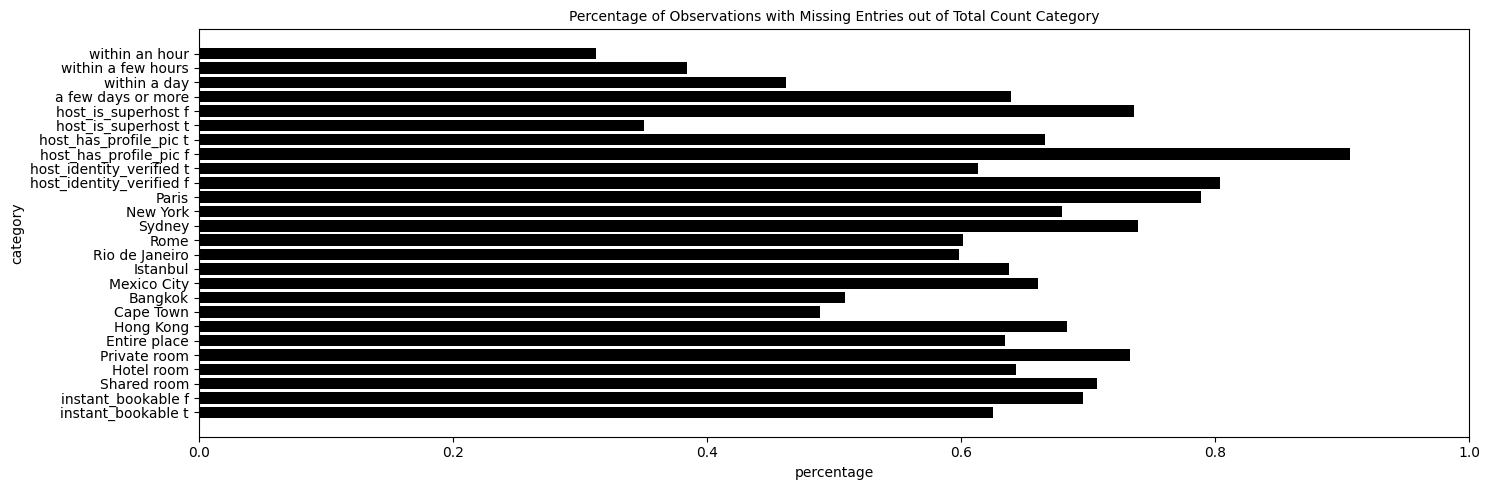

In [227]:
#@title MISSING VALS

CATEGORICAL_FEATURES = ['host_response_time','host_is_superhost','host_has_profile_pic','host_identity_verified','city','room_type','instant_bookable']

value_counts_original = pd.DataFrame(columns=['feature', 'value', 'count in original data'])
for column in CATEGORICAL_FEATURES:
    value_counts = ORIGINAL_DF[column].value_counts().reset_index()
    value_counts.columns = ['value', 'count in original data']
    value_counts['feature'] = column
    value_counts_original = value_counts_original.append(value_counts, ignore_index=True)

MISSING_DATA_POINTS = ORIGINAL_DF[ORIGINAL_DF.isna().any(axis=1)]
value_counts_missing = pd.DataFrame(columns = ['feature', 'value', 'count in missing data'])
for column in CATEGORICAL_FEATURES:
    value_counts = MISSING_DATA_POINTS[column].value_counts().reset_index()
    value_counts.columns = ['value', 'count in missing data']
    value_counts['feature'] = column
    value_counts_missing = value_counts_missing.append(value_counts, ignore_index=True)

common_values = set(value_counts_original['value']) & set(value_counts_missing['value'])
value_counts_original = value_counts_original[value_counts_original['value'].isin(common_values)].reset_index(drop = True)
value_counts_missing = value_counts_missing[value_counts_missing['value'].isin(common_values)].reset_index(drop = True)
value_counts_original['count in missing data'] = value_counts_missing['count in missing data']

value_counts_original['percentage'] = value_counts_original['count in missing data'] / value_counts_original['count in original data']

def modify_value(row):
    if row['value'] == 't' or row['value'] == 'f':
        return f"{row['feature']} {row['value']}"
    else:
        return row['value']

value_counts_original['value'] = value_counts_original.apply(modify_value, axis=1)

plt.figure(figsize=(15,5))
plt.barh(value_counts_original['value'], value_counts_original['percentage'], color='black')
plt.xlabel('percentage')
plt.ylabel('category')
plt.title('Percentage of Observations with Missing Entries out of Total Count Category', fontsize=10)
plt.gca().invert_yaxis()  # Invert y-axis to have higher percentages at the top
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [228]:
#@title WHAT DID WE DO HERE?

"""
* We filtered rows containing at least one missing value (a subset of data that would be removed using dropna).
* For each category we computed the count using value_counts.
* We divided these counts by value_counts that were calculated in the original dataset.
"""

'\n* We filtered rows containing at least one missing value (a subset of data that would be removed using dropna).\n* For each category we computed the count using value_counts.\n* We divided these counts by value_counts that were calculated in the original dataset.\n'

Became evident that a substantial percentage of values in several categories would be removed. However missing values are not concentrated within specific categories but rather distributed throughout the dataset.

considering **a** the insights gained from our investigations **b** the substantial size of dataset **c** our inclination to avoid imputation which could compromise the data's accuracy and introduce uncertainty by generating speculative values we've opted to proceed with the removal of the rows containing missing values.

In [229]:
ORIGINAL_DF = ORIGINAL_DF.dropna()

In [230]:
ORIGINAL_DF.isna().sum() # NO missing values!

listing_id                     0
name                           0
host_id                        0
host_since                     0
host_location                  0
host_response_time             0
host_response_rate             0
host_acceptance_rate           0
host_is_superhost              0
host_total_listings_count      0
host_has_profile_pic           0
host_identity_verified         0
neighbourhood                  0
city                           0
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bedrooms                       0
amenities                      0
price                          0
minimum_nights                 0
maximum_nights                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_sco

In [231]:
ORIGINAL_DF[ORIGINAL_DF['host_total_listings_count'] == 0].shape[0] # 8892 missing!

8892

But... There are missing values that were "disguised"? This makes sense as hosts not always report their number of properties. There is a more effective strategy for managing these misleading null rather than discarding this data?

In [232]:
ORIGINAL_DF[ORIGINAL_DF['host_total_listings_count'] == 0]['host_id'].value_counts()

371972456    55
336064553    24
341188013    20
364111358    18
376388906    16
             ..
308709389     1
290281204     1
38391974      1
336066739     1
237396157     1
Name: host_id, Length: 7207, dtype: int64

In [233]:
#@title DO IMPUTATION

imputation_counts = ORIGINAL_DF[ORIGINAL_DF['host_total_listings_count'] == 0]['host_id'].value_counts()
for index,row in ORIGINAL_DF[ORIGINAL_DF['host_total_listings_count'] == 0].iterrows():
    ORIGINAL_DF.at[index,'host_total_listings_count'] = imputation_counts[row['host_id']]

### SCALING PRICES

KAGGLE has indicated [HERE](https://www.kaggle.com/datasets/mysarahmadbhat/airbnb-listings-reviews) that the prices are denominated in local currency. To facilitate meaningful comparisons between various values we'll implement a transformation of the values in this variable which are expressed in different units - into US dollars.

In [234]:
exchange_rates = {
    'Paris': 0.85,        # 1 EUR = 0.85 USD
    'New York': 1.0,      # 1 USD = 1.0 USD (USD to USD is 1)
    'Bangkok': 0.030,     # 1 THB = 0.030 USD
    'Rio de Janeiro': 0.18,  # 1 BRL = 0.18 USD
    'Sydney': 0.75,       # 1 AUD = 0.75 USD
    'Istanbul': 0.12,     # 1 TRY = 0.12 USD
    'Rome': 1.20,         # 1 EUR = 1.20 USD
    'Hong Kong': 0.13,    # 1 HKD = 0.13 USD
    'Mexico City': 0.050, # 1 MXN = 0.050 USD
    'Cape Town': 0.066    # 1 ZAR = 0.066 USD
}

In [235]:
ORIGINAL_DF['price'] = ORIGINAL_DF.apply(lambda row : exchange_rates[row['city']] * row['price'], axis=1)

### CLEAN ERRORES

In [236]:
statistics = ORIGINAL_DF[FEATURES_TO_DETECT_ERRORS].describe(percentiles = [0.01,0.05,0.1,0.2,0.25,0.3,0.4,0.5,
                                                                            0.6,0.7,0.75,0.8,0.9,0.95,0.99,0.999]).drop(index='count').transpose()

In [237]:
{'minimum nights' : tuple(ORIGINAL_DF['minimum_nights'].nlargest(5)), 'maximum nights' : tuple(ORIGINAL_DF['maximum_nights'].nlargest(25))}

{'minimum nights': (1000, 1000, 600, 600, 523),
 'maximum nights': (999999999,
  999999,
  200000,
  99999,
  50000,
  50000,
  50000,
  47036,
  30000,
  30000,
  30000,
  10000,
  10000,
  10000,
  9999,
  9999,
  9999,
  9999,
  9999,
  7000,
  5000,
  5000,
  3659,
  3500,
  3333)}

We can get an impression from AIRBNB website in
[
this link](https://he.airbnb.com/resources/hosting-homes/a/understanding-your-calendar-and-booking-settings-16)
regarding what considered a reasonable length of stay. A stay of 28 days or more is considered long. We can conclude that:

While some properties may require longer stays due to their unique nature (such as vacation rentals in less accessible areas) the imposition of minimum night requirements on such a significant scale counterintuitive to the concept of AIRBNB which is designed to offer flexible and short term lodging options for travelers.

The entries in maximum nights deviate from the typical pattern in standard AIRBNB hosting policies (presenting "strange" numbers like 99999). Look at minimum nights for those who have unreasonable maximum nights. What can this teach us?

In [238]:
ORIGINAL_DF.loc[ORIGINAL_DF['maximum_nights'].nlargest(25).index][['minimum_nights', 'maximum_nights']]

,minimum_nights,maximum_nights
268454,1,999999999
159137,1,999999
205366,1,200000
202804,1,99999
157834,1,50000
186141,1,50000
186333,1,50000
222113,1,47036
159828,1,30000
186768,1,30000


Most hosts have a minimal night requirement indicating a likelihood of them being flexible and lack a concrete or defined time limit. What is the most probable value associated with those listings? (it can be inferred that 1125 which is the upper limit that constitute 50% of the distribution).

In [239]:
#@title ERRORED VALS

ORIGINAL_DF = ORIGINAL_DF.loc[ORIGINAL_DF[ORIGINAL_DF['minimum_nights'] <= 365].index] # removal

In [240]:
#@title ERRORED VALS

ORIGINAL_DF.loc[(ORIGINAL_DF['maximum_nights'] >= 3333),'maximum_nights'] = 1125 # substitute

While it is not impossible for someone to have a high number of properties - having a count of above 2500 properties attributed to a single host might raises suspicions of data entries errors. Let's check it:

In [241]:
#@title ERRORED VALS

ORIGINAL_DF[ORIGINAL_DF['host_total_listings_count'] > 1000][['host_total_listings_count','host_id']]

,host_total_listings_count,host_id
44217,1105.0,33889201
44218,1105.0,33889201
44246,1105.0,33889201
44247,1105.0,33889201
44249,1105.0,33889201
...,...,...
176223,2739.0,194953121
176224,2739.0,194953121
205148,1337.0,270230010
205374,1337.0,270230010


Given their huge number of properties we would perhaps expect more registrations from those hosts (as we can observe among the other hosts who have multiple properties).

In [242]:
ORIGINAL_DF = ORIGINAL_DF.loc[ORIGINAL_DF[ORIGINAL_DF['host_total_listings_count'] < 2500].index] # removing those instance

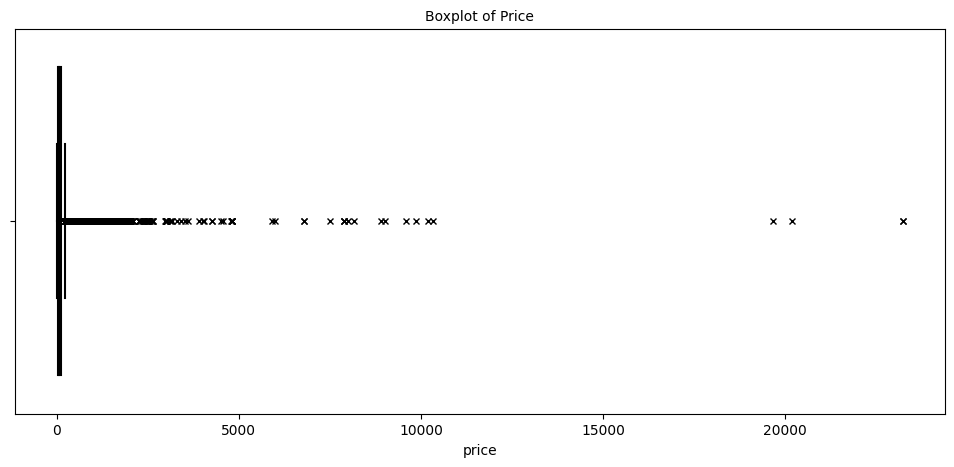

In [243]:
#@title ERRORED VALS

plt.figure(figsize=(12,5))
sns.boxplot(x = ORIGINAL_DF['price'], color='black', flierprops={'marker' : 'x'})
plt.xlabel('price')
plt.title('Boxplot of Price',fontsize=10)
plt.show()

Let's get insight into the high price of one of them through "name" attribute which provide some description:

In [244]:
#@title ERRORED VALS

ORIGINAL_DF.loc[36228][['name','price']]

name     Cute 1 bedroom flat in the center of Paris.
price                                        10200.0
Name: 36228, dtype: object

Evident that the price NOT should be 10200$ for a single night...

In [245]:
ORIGINAL_DF = ORIGINAL_DF.loc[ORIGINAL_DF[ORIGINAL_DF['price'] < 10000].index] # removing them

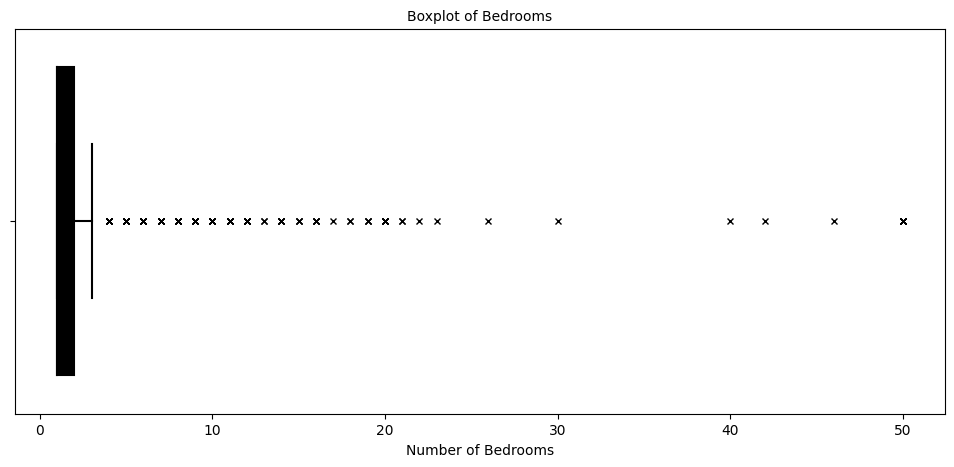

In [246]:
#@title ERRORED VALS

plt.figure(figsize=(12,5))
sns.boxplot(x = ORIGINAL_DF['bedrooms'], color = 'black', flierprops = {'marker': 'x'})
plt.xlabel('Number of Bedrooms')
plt.title('Boxplot of Bedrooms', fontsize=10)
plt.show()

Which type of property might this characteristic align with 50 bedrooms?

In [247]:
ORIGINAL_DF.loc[ORIGINAL_DF['bedrooms'] == 50][['bedrooms','accommodates','property_type']].iloc[2] # sample one of the points whose value in bedrooms feature is 50

bedrooms                  50.0
accommodates                 2
property_type    Room in hotel
Name: 95290, dtype: object

Must be an error..... Let's delve into a more deep exploration regarding it!

In [248]:
#@title ERRORED VALS

ORIGINAL_DF.loc[ORIGINAL_DF['bedrooms'] > 20][['bedrooms','accommodates','property_type','room_type','name']]

,bedrooms,accommodates,property_type,room_type,name
44226,50.0,16,Entire apartment,Entire place,Ã¢ÅÂ¯ Amazing Midtown Suites for Home Office ...
91828,30.0,16,Room in aparthotel,Private room,Bahcelievler Ã Å¾irinevler MeydanÃÂ±nda GÃÂ¼...
92055,42.0,2,Private room in bed and breakfast,Private room,Huzurun Istanbuldaki adresi ISTPORT HOTEL
92133,50.0,16,Room in bed and breakfast,Hotel room,Ã¢ÅÂ¯ MASTER SUITES PRIME LOCATION Ã¢ÅÂ¯
94197,46.0,4,Room in boutique hotel,Private room,welcome to hotel next2
94886,21.0,2,Room in boutique hotel,Private room,Palmiye suit otel
94949,26.0,2,Room in hotel,Private room,LUXURY HOTEL with disinfection certificated
95290,50.0,2,Room in hotel,Private room,Grand Ã Å¾ile Hotel
202737,50.0,16,Room in boutique hotel,Private room,Rooms heart of Saint-Germain des Pres Paris
202766,40.0,2,Private room in bed and breakfast,Private room,"Bellevue Manor, SEA POINT, Cape Town"


Further analysis reveals inconsistencies in features within dataset. For instance it is illogical for a private room in an hotel	to be associated with 26 bedrooms and accommodation for 2 people. These discrepancies introduce errors and inaccuracies in the data.

We also observe that "Hotel Room" as well as "Boutique Hotel Room" properties categorized as "Private Room" instead of the anticipated "Hotel Room". This incongruence could be attributed to arbitrary data entry practices or the host's misunderstanding of the classification of the various categories.

In [249]:
ORIGINAL_DF.loc[(((ORIGINAL_DF['property_type'] == 'Room in boutique hotel')  | (ORIGINAL_DF['property_type'] == 'Room in hotel')) & (ORIGINAL_DF['room_type'] == 'Entire place')) | ((ORIGINAL_DF['property_type'] == 'Room in apartment'))][['property_type','room_type','name']].iloc[:5]

,property_type,room_type,name
78352,Room in apartment,Hotel room,"Luxury Style,Walking to Darling Harbour,QVB,ICC."
92785,Room in apartment,Hotel room,Kylemore 407 - Two Bedroom Apartment
95269,Room in boutique hotel,Entire place,FAÃâ¡ÃÂ°BA BUTÃÂ°K OTEL
103457,Room in boutique hotel,Entire place,Studio.Perfect Location. Near Blue Mosque
129010,Room in boutique hotel,Entire place,Bungalow in a secret garden


In [250]:
ORIGINAL_DF[(ORIGINAL_DF['property_type'] == 'Room in aparthotel')]['room_type'].value_counts() # seems like apartment hotel can be interpreted as a room (private or hotel) or as an entire place

Entire place    309
Private room    153
Hotel room      117
Name: room_type, dtype: int64

We'll adjust these misclassifications for better coherence. We also preserve just entries where the count of accommodations aligns with or remains above the available bedrooms as the host wouldn't assign larger space for a smaller number of occupants.

In [251]:
#@title ERRORED VALS

# in "Room in aparthotel" we're changing the room categorization to "Entire place" which is most common subcategories).

conditions = [
    ORIGINAL_DF['property_type'] == 'Room in apartment',
    ORIGINAL_DF['property_type'] == 'Room in boutique hotel',
    ORIGINAL_DF['property_type'] == 'Room in hotel',
    ORIGINAL_DF['property_type'] == 'Room in aparthotel'
]

ORIGINAL_DF['room_type'] = np.select(conditions,['Private room','Hotel room','Hotel room','Entire place'],ORIGINAL_DF['room_type'])

In [252]:
#@title ERRORED VALS

ORIGINAL_DF = ORIGINAL_DF.loc[ORIGINAL_DF[(ORIGINAL_DF['bedrooms'] <= ORIGINAL_DF['accommodates'])].index]

### LOG THE PRICES

As evident from the provided statistics the price distribution displays a right-skewed pattern (noticeable due to the median falling below the mean). Let's use a logarithmic function to target variable to better fit a linear model.

In [253]:
#@title LOGARITHMIC

ORIGINAL_DF['price_log'] = np.log((ORIGINAL_DF['price']))
ORIGINAL_DF = ORIGINAL_DF.drop(columns='price')

### CONTINUE WITH EXPLORATORY DATA ANALYSIS

In [254]:
{'nuniques' : ORIGINAL_DF['neighbourhood'].nunique(), 'nuniques with 10 listings or fewer' : ORIGINAL_DF['neighbourhood'].value_counts()[ORIGINAL_DF['neighbourhood'].value_counts() < 10].shape[0]}

{'nuniques': 595, 'nuniques with 10 listings or fewer': 215}

In [255]:
{'nuniques' : ORIGINAL_DF['property_type'].nunique(), 'nuniques with 10 listings or fewer' : ORIGINAL_DF['property_type'].value_counts()[ORIGINAL_DF['property_type'].value_counts() < 10].shape[0]}

{'nuniques': 104, 'nuniques with 10 listings or fewer': 47}

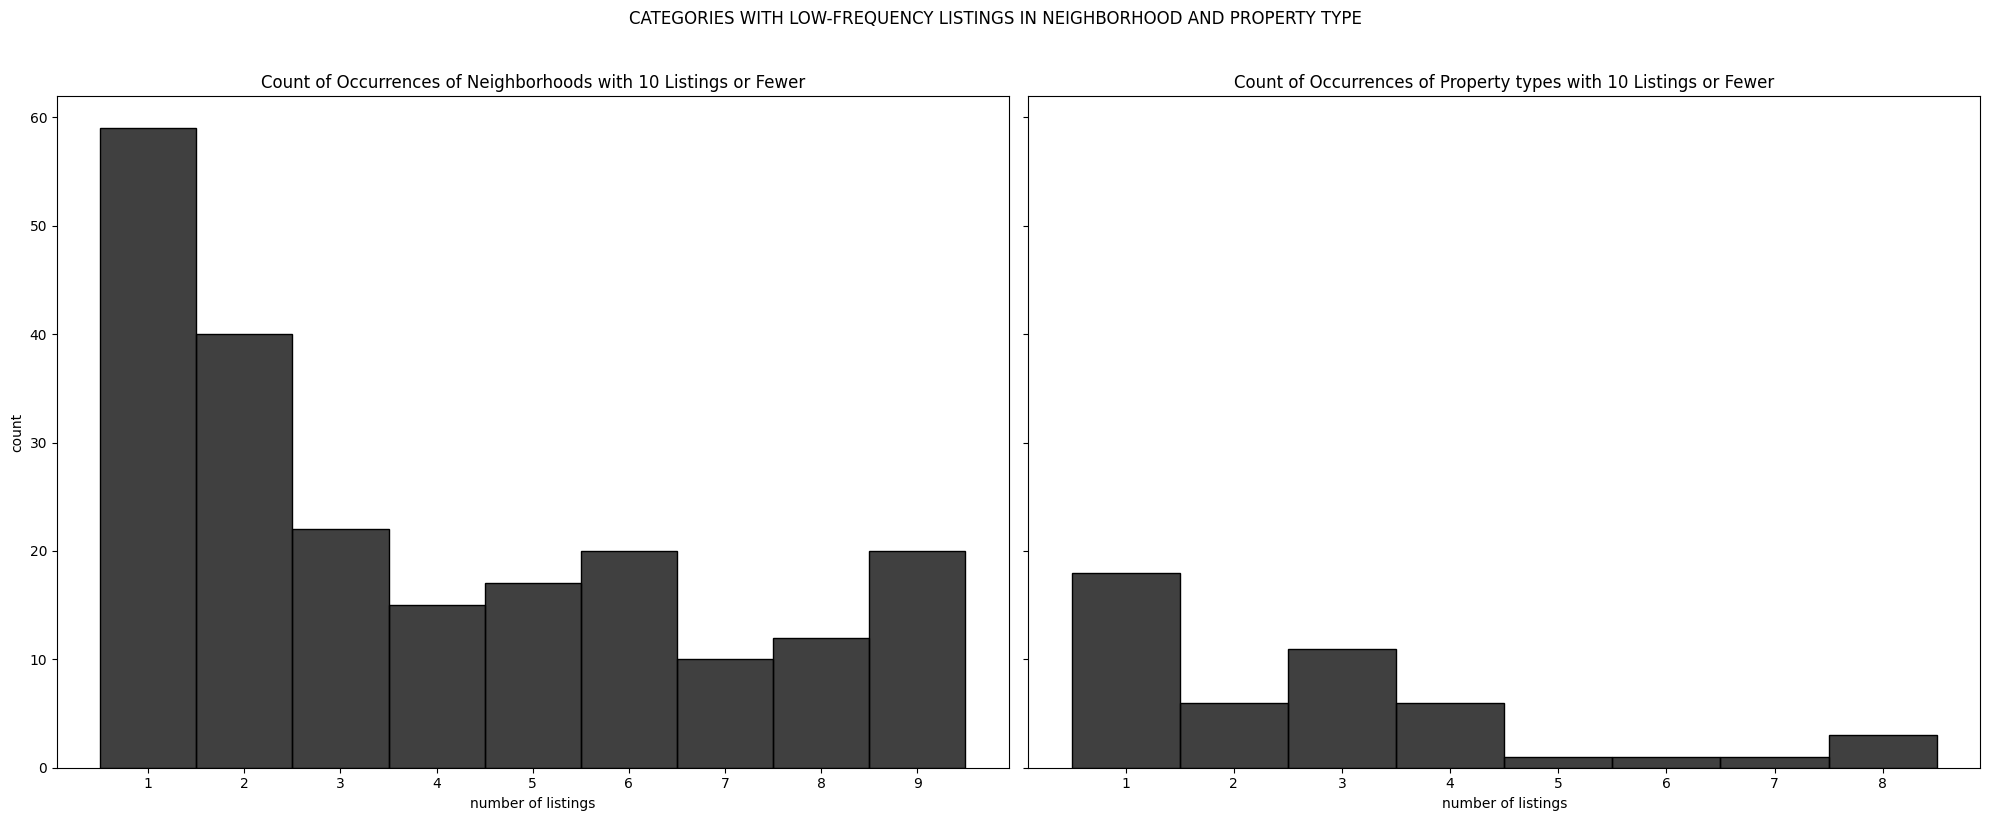

In [256]:
#@title U CATEGORIES

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8), sharey=True)

plt.sca(axs[0])
sns.histplot(ORIGINAL_DF['neighbourhood'].value_counts()[ORIGINAL_DF['neighbourhood'].value_counts() < 10], color='black', discrete = True)
plt.title('Count of Occurrences of Neighborhoods with 10 Listings or Fewer')
plt.ylabel('count')
plt.xlabel('number of listings')
plt.xticks(range(1,10))

plt.sca(axs[1])
sns.histplot(ORIGINAL_DF['property_type'].value_counts()[ORIGINAL_DF['property_type'].value_counts() < 10], color='black', discrete = True)
plt.title('Count of Occurrences of Property types with 10 Listings or Fewer')
plt.ylabel('count')
plt.xlabel('number of listings')
plt.xticks(range(1,9))



fig.suptitle('Categories with Low-Frequency Listings in neighborhood and property type'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

There are lot of categories with low count and some with only one observation. What should we do? Let's continue to explore a little more to gain insight:

In [257]:
ORIGINAL_DF['room_type'].unique()

array(['Entire place', 'Private room', 'Hotel room', 'Shared room'],
      dtype=object)

In [258]:
'Entire place' in ORIGINAL_DF['property_type'].unique()

True

In [259]:
'Private room' in ORIGINAL_DF['property_type'].unique()

True

To what extent does this feature contribute meaningful information to our  dataset? MULTICOLLINEARITY???

In [260]:
#@title CLEANE COLS

FEATURES_TO_DROP = ['listing_id','host_location','name','latitude','longitude','neighbourhood','property_type']
ORIGINAL_DF = ORIGINAL_DF.drop(columns=FEATURES_TO_DROP)

### NOVEL FEATURES

We'll now generate novel features through leveraging the existing data attributes! Let's start with amenities.

In [261]:
ORIGINAL_DF['amenities'] # this feature needs to be encoded or represented in an other manner

26273     ["Shampoo", "Dishes and silverware", "Heating"...
26274     ["Elevator", "Dishes and silverware", "Hangers...
26275     ["Shampoo", "Oven", "Heating", "Washer", "Dedi...
26276     ["Nespresso machine", "Single level home", "Mi...
26277     ["Paid parking garage off premises", "Refriger...
                                ...                        
271181    ["Dishwasher", "Essentials", "Hot water", "Han...
271182    ["Pool", "Private entrance", "Shampoo", "Heati...
271183    ["Dishwasher", "Essentials", "Air conditioning...
271184    ["Extra pillows and blankets", "Heating", "TV"...
271185    ["Cooking basics", "Ethernet connection", "Hea...
Name: amenities, Length: 92834, dtype: object

In [262]:
#@title SEE THIS CODE

# We'll create a list of amenities listed on the AIRBNB website and generate binary columns to depict whether listing possessed specific amenity.

our_amenities = ['TV','FREEZER','WIFI','KITCHEN','WASHER','DRYER','AIR CONDITIONING','HEATING','WORKSPACE','IRON','POOL','FREE PARKING','CRIB',
                 'BBQ GRILL','INDOOR FIREPLACE','HOT TUB','EV CHARGER','GYM','BREAKFAST','SMOKING ALLOWED','BEACHFRONT','WATERFRONT','SMOKE ALARM','CARBON MONOXIDE ALARM']

for am in our_amenities:
  ORIGINAL_DF[am] = None
  ORIGINAL_DF[am] = ORIGINAL_DF['amenities'].apply(lambda x : int(am in x.upper()))

ORIGINAL_DF = ORIGINAL_DF.drop(columns=['amenities'])

In [263]:
ORIGINAL_DF['num_amenities'] = ORIGINAL_DF[our_amenities].sum(axis=1) # INTRODUCING NEW FEATURE

In [264]:
ORIGINAL_DF['host_since']

26273     2019-10-30
26274     2019-11-28
26275     2019-12-03
26276     2019-11-08
26277     2019-10-11
             ...    
271181    2020-07-17
271182    2012-10-18
271183    2016-05-25
271184    2012-05-26
271185    2015-05-01
Name: host_since, Length: 92834, dtype: object

Based on the most recent update date of the file which appears to be from 2019 we'll subtract the year provided in the date from 2019. That way we can generate a numerical feature representing the host's duration of membership with airbnb. This metric could offer a sense of the host's level of experience and tenure within the platform.

In [265]:
#@title SEE THIS CODE

ORIGINAL_DF['host_since'] = ORIGINAL_DF['host_since'].apply(lambda x : 2021 - int(x.split('-')[0]))

### CLEAN OUTLIERS

Having addressed values that are unrealistic we'll now handle values within the realm of the distribution but are significantly distant from the reasonable range.

**NOTE** we made decision not to treat outliers across reviews. Lower ratings are essential for comprehending the complete range of customer experiences.

In [266]:
#@title CLEAN POINTS

NUMERICAL_FETURES_ORTALIERS = ['host_response_rate','host_acceptance_rate','minimum_nights','maximum_nights','host_total_listings_count','price_log']

In [267]:
statistics = ORIGINAL_DF[NUMERICAL_FETURES_ORTALIERS].describe(percentiles = [0.01,0.05,0.1,0.2,0.25,0.3,0.4,0.5,
                                                                              0.6,0.7,0.75,0.8,0.9,0.95,0.99,0.999]).drop(index='count').transpose()

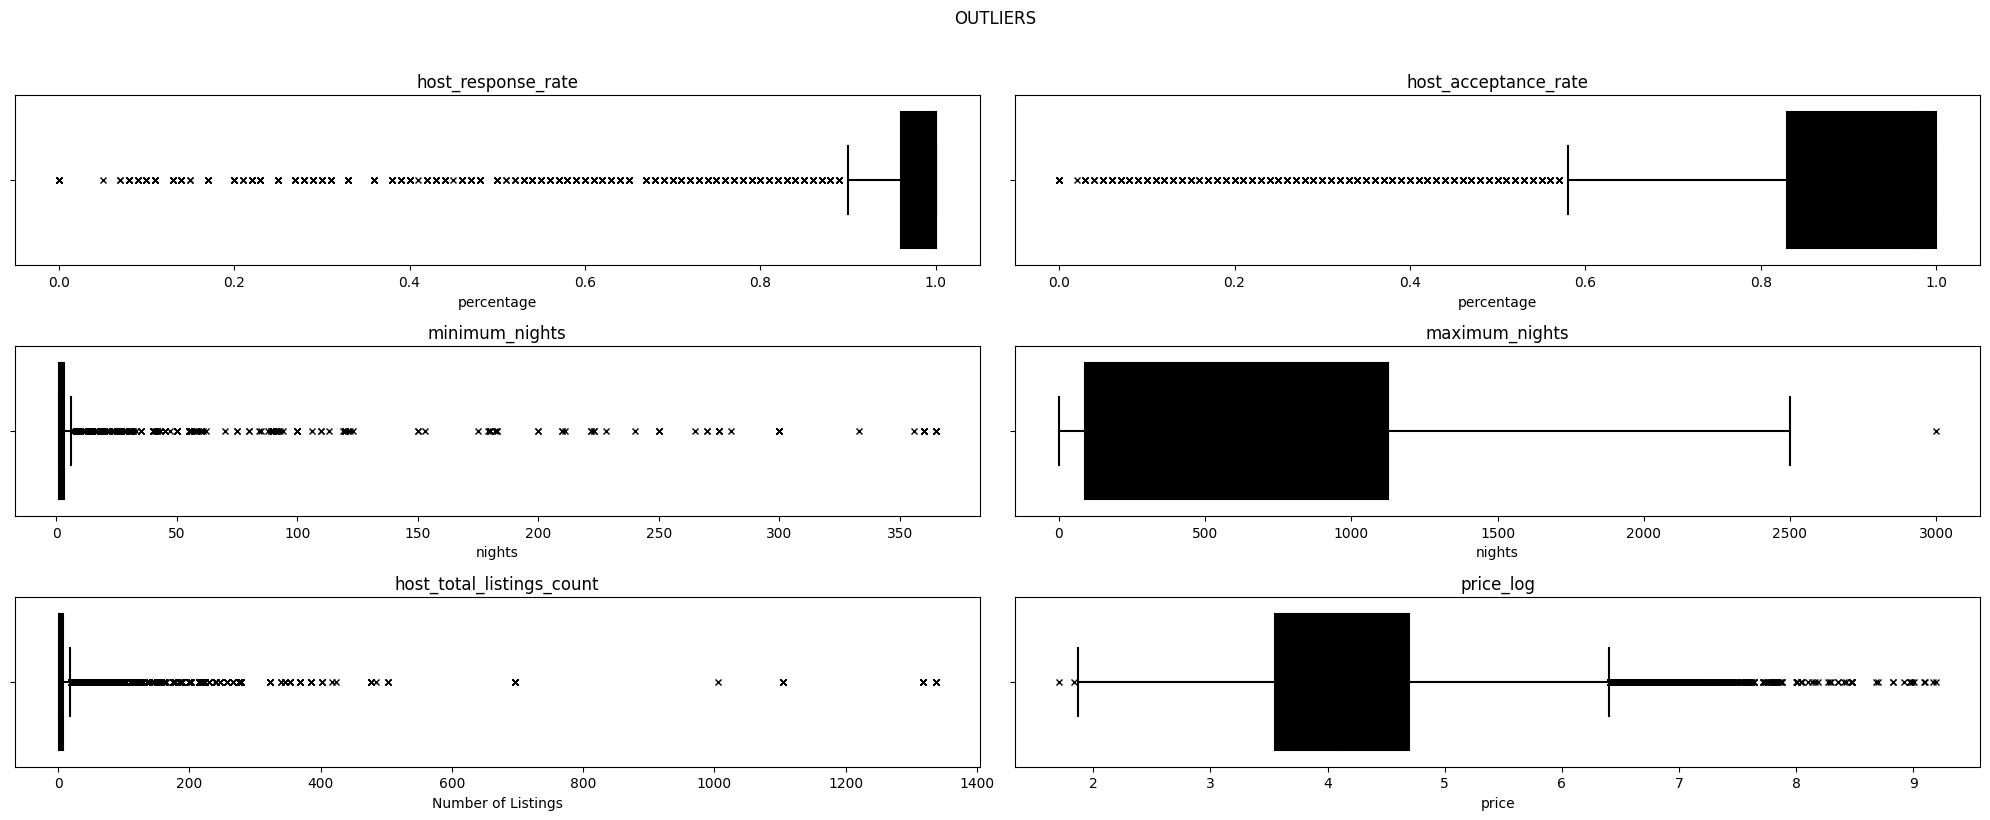

In [268]:
#@title CLEAN POINTS

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,8))

for i, feature in enumerate(NUMERICAL_FETURES_ORTALIERS):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    sns.boxplot(x=feature, color='black', flierprops={'marker': 'x'}, data=ORIGINAL_DF[NUMERICAL_FETURES_ORTALIERS], ax=ax)
    ax.set_title(feature)
    if feature in ['host_response_rate','host_acceptance_rate']:
      ax.set_xlabel('percentage')
    elif feature in ['minimum_nights','maximum_nights']:
      ax.set_xlabel('nights')
    elif feature == 'host_total_listings_count':
      ax.set_xlabel('Number of Listings')
    else:
      ax.set_xlabel('price')

fig.suptitle('outliers'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.6, wspace=0.4)
plt.tight_layout()
plt.show()

In the host total listings count some hosts possess substantial number of assets which skewing the distribution towards one end of the scale. Establishing a threshold becomes challenging and becomes a factor integrated into the statistical summaries to ensure accurate and relevant analyses.

ALSO.... DO YOU SEE THE TREND?? (all outliers come from one direction). What can this teach us about the distributions?

In [269]:
ORIGINAL_DF = ORIGINAL_DF.loc[((ORIGINAL_DF['host_response_rate'] > 0.9) & (ORIGINAL_DF['host_acceptance_rate'] > 0.6) &
                               (ORIGINAL_DF['minimum_nights'] < 40) &
                               (ORIGINAL_DF['host_total_listings_count'] < 20) & (ORIGINAL_DF['price_log'] < 7.5)),:].reset_index(drop=True)

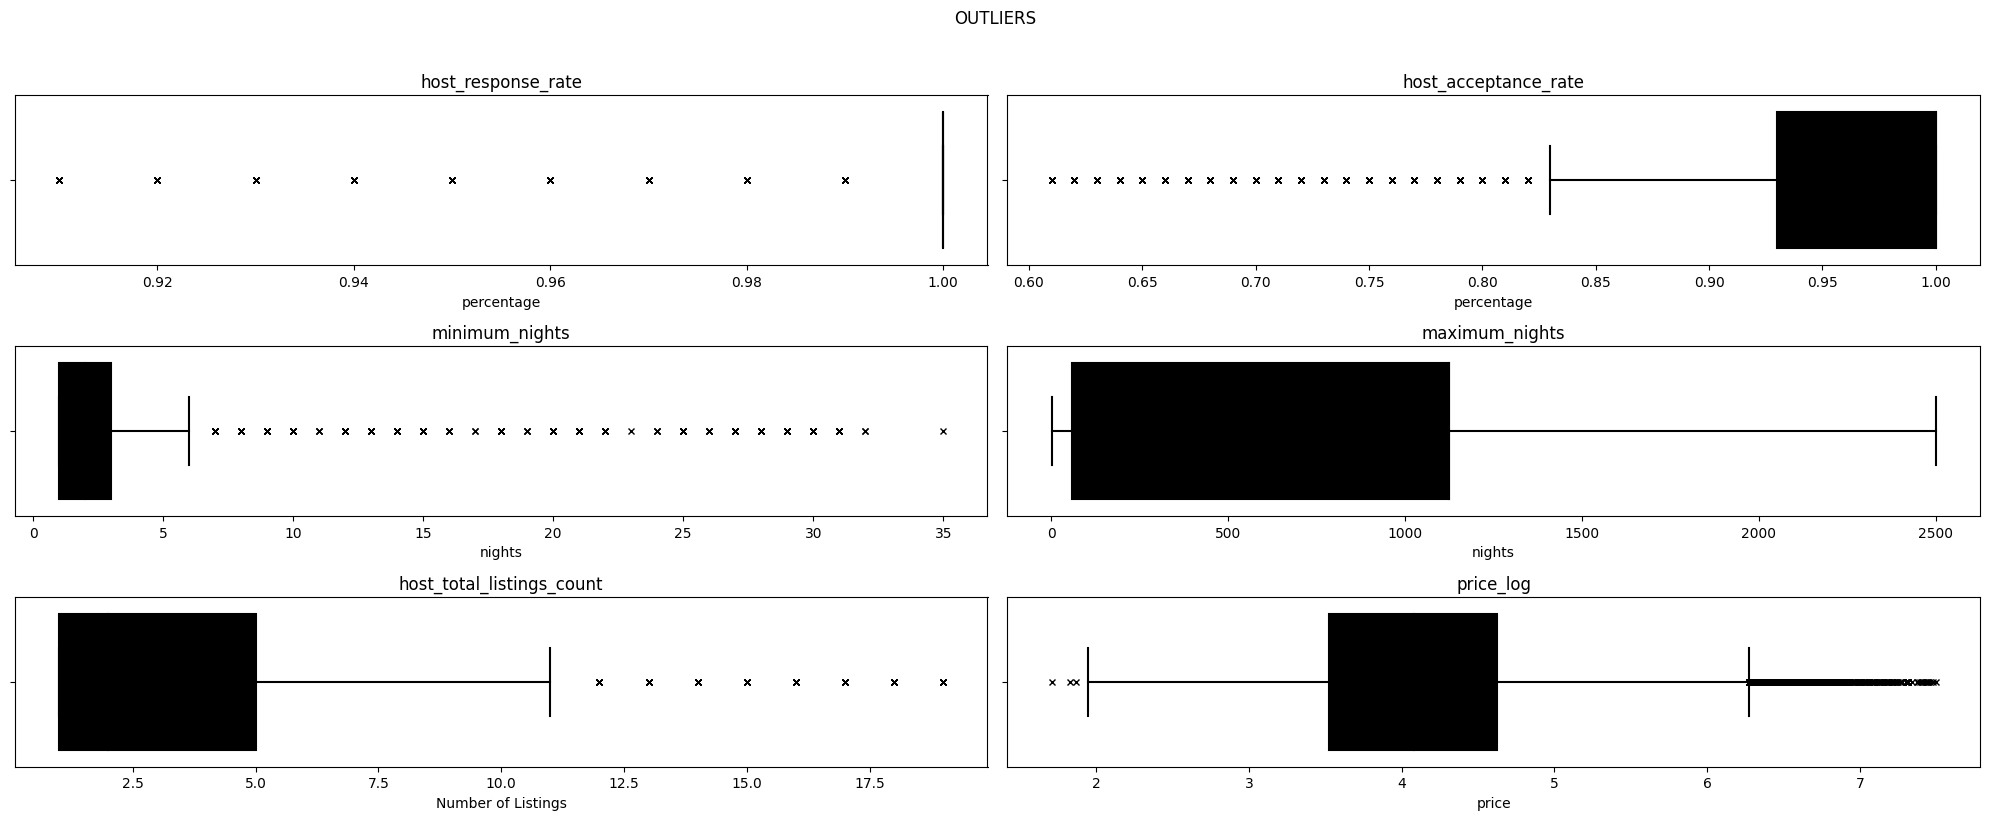

In [270]:
#@title CLEAN POINTS

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,8))

for i, feature in enumerate(NUMERICAL_FETURES_ORTALIERS):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    sns.boxplot(x=feature, color='black', flierprops={'marker': 'x'}, data=ORIGINAL_DF[NUMERICAL_FETURES_ORTALIERS], ax=ax)
    ax.set_title(feature)
    if feature in ['host_response_rate','host_acceptance_rate']:
      ax.set_xlabel('percentage')
    elif feature in ['minimum_nights','maximum_nights']:
      ax.set_xlabel('nights')
    elif feature == 'host_total_listings_count':
      ax.set_xlabel('Number of Listings')
    else:
      ax.set_xlabel('price')

fig.suptitle('outliers'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.6, wspace=0.4)
plt.tight_layout()
plt.show()

One technique in managing outliers within multidimensional data is examining the distribution of distances between each data point and its closest neighbor. Let's use it to examine further the dataset's structure after removing  outliers.

Text(0, 0.5, 'count')

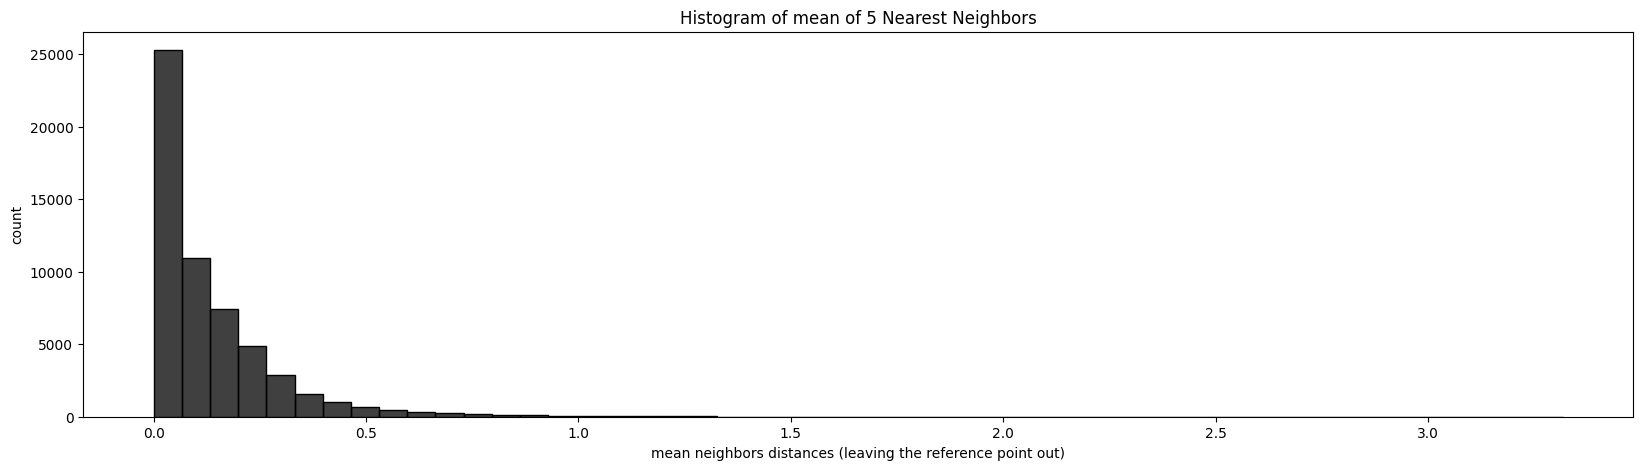

In [271]:
#@title CLEAN POINTS

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(ORIGINAL_DF[NUMERICAL_FETURES_ORTALIERS])
normalized_df = pd.DataFrame(normalized_data, columns = ORIGINAL_DF[NUMERICAL_FETURES_ORTALIERS].columns)

n = NearestNeighbors(metric='euclidean')
n.fit(normalized_df)

distances, _ = n.kneighbors(normalized_df, 6)
mean_distances = distances[:,1:].mean(axis=1)
plt.figure(figsize=(20,5))
sns.histplot(mean_distances, color='black', bins=50)
plt.xlabel('mean neighbors distances (leaving the reference point out)')
plt.title('Histogram of mean of 5 Nearest Neighbors')
plt.ylabel('count')

This hist illustrates the mean Euclidean distances for each data point computed from its five nearest neighbors. Prior to applying the algorithm the data underwent normalization due to the varying units of our features. IT'S LOOK GOOD!

 We will also exclude values within the discrete features that exhibit small sizes and so low likelihood of appearing in both training and test sets.

In [272]:
#@title CLEAN POINTS

MY_DISCRETE = ['bedrooms','num_amenities','accommodates','host_since']

for FEATURE in MY_DISCRETE:
  if 1 in ORIGINAL_DF[FEATURE].value_counts():
    ORIGINAL_DF = ORIGINAL_DF.loc[ORIGINAL_DF[FEATURE].isin(ORIGINAL_DF[FEATURE].value_counts()[ORIGINAL_DF[FEATURE].value_counts() > 10].index),:]

In [273]:
ORIGINAL_DF.shape # inspect table dimensions after cleaning the dataset

(56432, 49)

### NOVEL FEATURES

We will merge new attribute from "minimum_nights" "maximum_nights" to better capture the underlying information these features hold.

In [274]:
statistics = ORIGINAL_DF[['maximum_nights','minimum_nights']].describe(percentiles = [0.01,0.05,0.1,0.2,0.25,0.3,0.4,0.5,
                                                                                      0.6,0.7,0.75,0.8,0.9,0.95,0.99,0.999]).drop(index = 'count').transpose()

In [275]:
#@title SEE THIS CODE

# High value for minimum nights suggests that the host caters to longer stays while low value for maximum nights suggests that the host caters
# to shorter stays. Instances where minimum nights is low or maximum nights is high present a nuanced scenario. Host can prefere shorter stays
# (if maximum nights is low) or longer stays (minimum nights is high). The host's might also allow both shorter and longer stays based on guest
# preferences (low minimum nights and  high maximum night).


def categorize_s(row):

    if row['minimum_nights'] >= 28:
        return 'Long'
    elif row['maximum_nights'] <= 14:
        return 'Short'
    else:
        return 'Flexible'

ORIGINAL_DF['stay_duration'] = ORIGINAL_DF.apply(categorize_s, axis=1)

ORIGINAL_DF = ORIGINAL_DF.drop(columns=['maximum_nights','minimum_nights'])

ORIGINAL_DF = ORIGINAL_DF.reset_index(drop=True)

### CONTINUE WITH EXPLORATORY DATA ANALYSIS

The EDA in the initial stages served as a supporter of the preprocessing. It elaborated familiarity with the data in its raw version as well as providing clarity regarding data quality (potential problems and errors) and guided the necessary adjustments.

With this basic step completed we get clean data and the focus shifted to a more comprehensive EDA regarding basic patterns in the data.

In [276]:
#@title FRATURES DICT

FEATURES_DICT = {'NUMERICAL FEATURES HOST' : ['host_response_rate','host_acceptance_rate'],
                 'REVIEWS' : ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value'],
                 'CATEGORICAL FEATURES HOST' :  ['host_total_listings_count','host_since','host_is_superhost','host_has_profile_pic','host_identity_verified','host_response_time'],
                 'CATEGORICAL FEATURES PROPERTY' : ['city','room_type','instant_bookable','stay_duration','bedrooms','num_amenities','accommodates'],
                 'AMENITIES' : our_amenities,
                 'SPECIFIC REVIEWS' : ['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']}

In [277]:
ORIGINAL_DF.columns # note we treat during dataset preparation some numerical features with discrete values as categorical

Index(['host_id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'city', 'room_type', 'accommodates',
       'bedrooms', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'price_log', 'TV', 'FREEZER',
       'WIFI', 'KITCHEN', 'WASHER', 'DRYER', 'AIR CONDITIONING', 'HEATING',
       'WORKSPACE', 'IRON', 'POOL', 'FREE PARKING', 'CRIB', 'BBQ GRILL',
       'INDOOR FIREPLACE', 'HOT TUB', 'EV CHARGER', 'GYM', 'BREAKFAST',
       'SMOKING ALLOWED', 'BEACHFRONT', 'WATERFRONT', 'SMOKE ALARM',
       'CARBON MONOXIDE ALARM', 'num_amenities', 'stay_duration'],
      dtype='object')

#### OUR FEATURES

<ipython-input-278-82a35d4c386a>:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ORIGINAL_DF['price_log'])


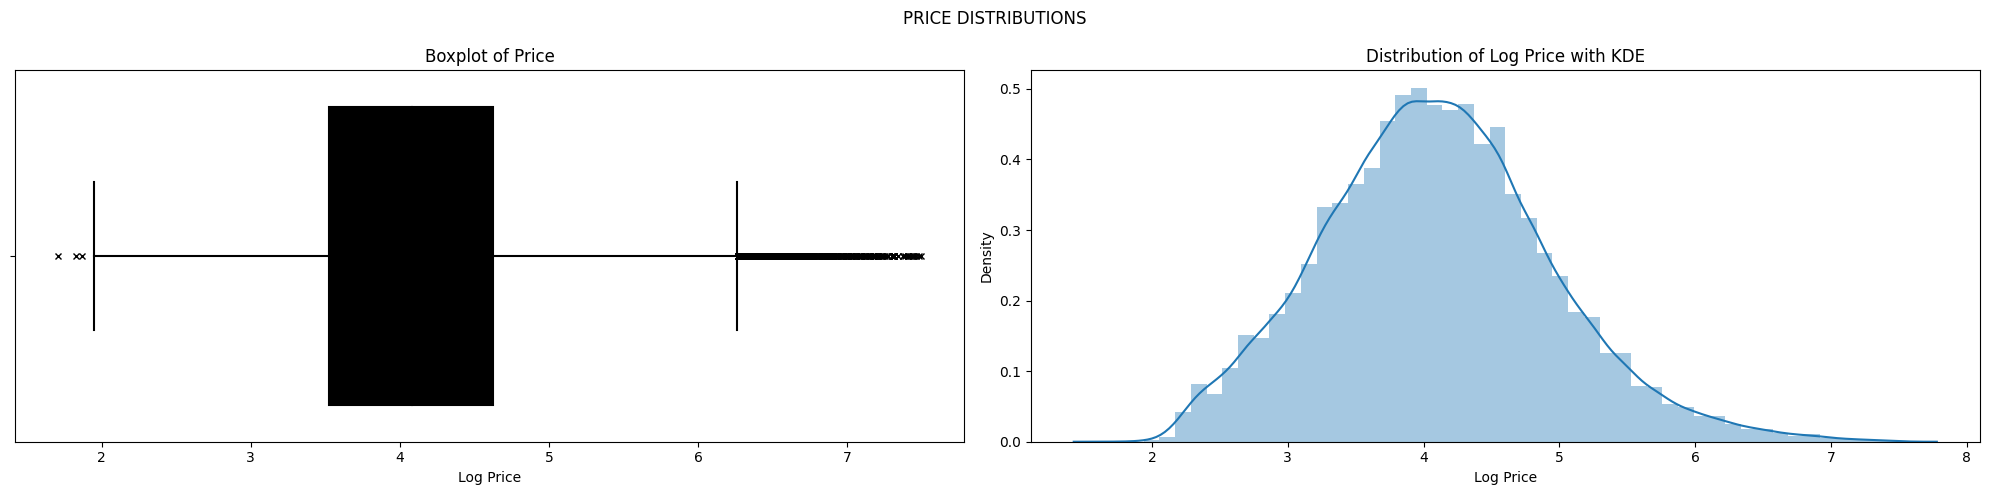

In [278]:
#@title VARIABLES (1)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

plt.sca(axs[0])
sns.boxplot(x = ORIGINAL_DF['price_log'], color='black', flierprops={'marker' : 'x'})
plt.xlabel('Log Price')
plt.title('Boxplot of Price')

plt.sca(axs[1])
sns.distplot(ORIGINAL_DF['price_log'])
plt.xlabel('Log Price')
plt.ylabel('Density')
plt.title('Distribution of Log Price with KDE')

fig.suptitle('PRICE DISTRIBUTIONS', fontsize=12)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)  # Adjust the values as needed
plt.tight_layout()
plt.show()

Through implementing logarithmic scale for the price we have managed to visualize its distribution resembling a Gaussian curve. However it's important to note that prices inherently tend to follow right-skewed distributions which means the data's actual distribution might deviate from the Gaussian-like appearance observed.

In [279]:
statistics = ORIGINAL_DF[FEATURES_DICT['REVIEWS'] + FEATURES_DICT['NUMERICAL FEATURES HOST']].describe(percentiles = [0.01,0.05,0.1,0.2,0.25,0.3,0.4,0.5,
                                                                                                                      0.6,0.7,0.75,0.8,0.9,0.95,0.99,0.999]).transpose()

In [280]:
statistics = tab_value_counts(ORIGINAL_DF[FEATURES_DICT['CATEGORICAL FEATURES HOST'] + FEATURES_DICT['CATEGORICAL FEATURES PROPERTY']], ORIGINAL_DF)

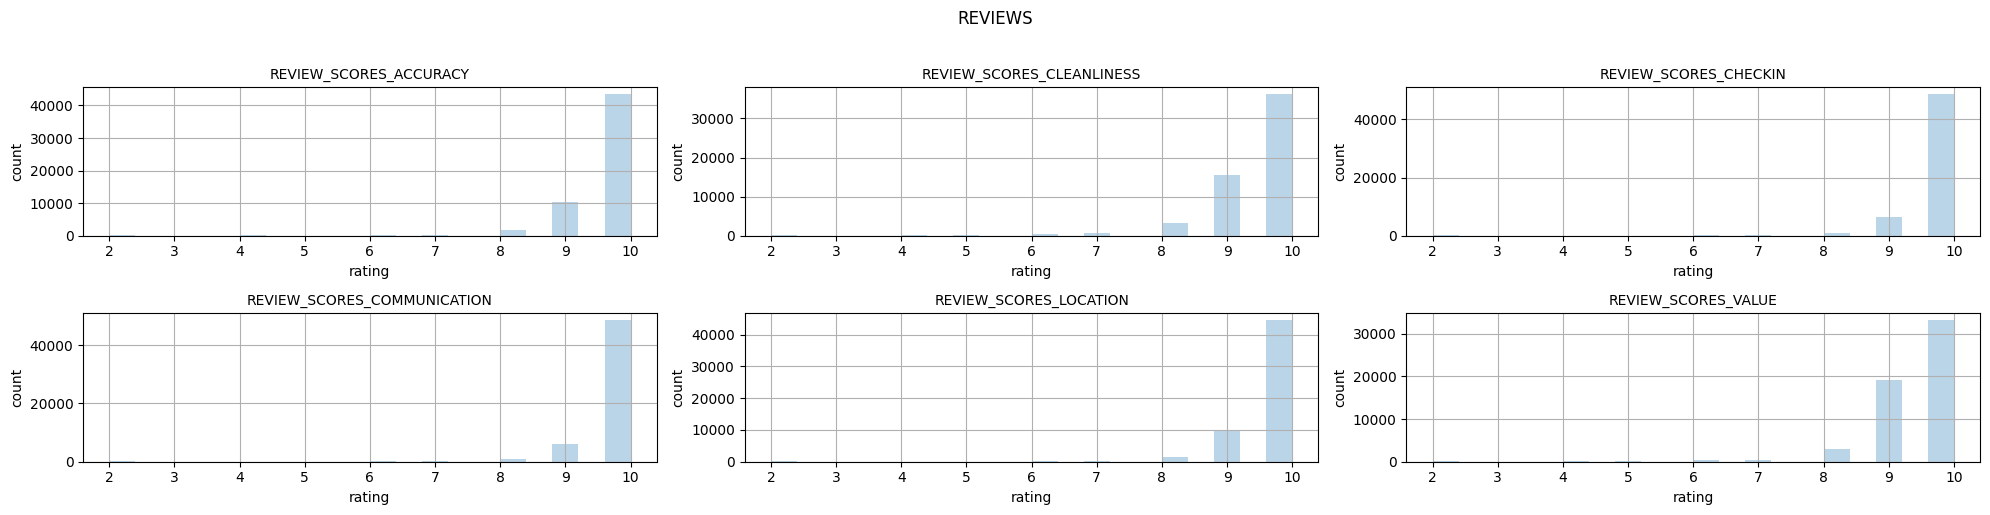

In [281]:
#@title VARIABLES (1)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20,5))
for idx, feature in enumerate(FEATURES_DICT['SPECIFIC REVIEWS']):
    row_idx = idx // 3  # Use 3 as the divisor
    col_idx = idx % 3   # Use 3 as the divisor
    plt.sca(axs[row_idx, col_idx])
    ORIGINAL_DF[feature].hist(bins=20, alpha=0.3)
    plt.xlabel('rating')
    plt.ylabel('count')
    plt.title(feature.upper(), fontsize=10)

fig.suptitle('REVIEWS'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.6, wspace=0.4)
plt.tight_layout()
plt.show()

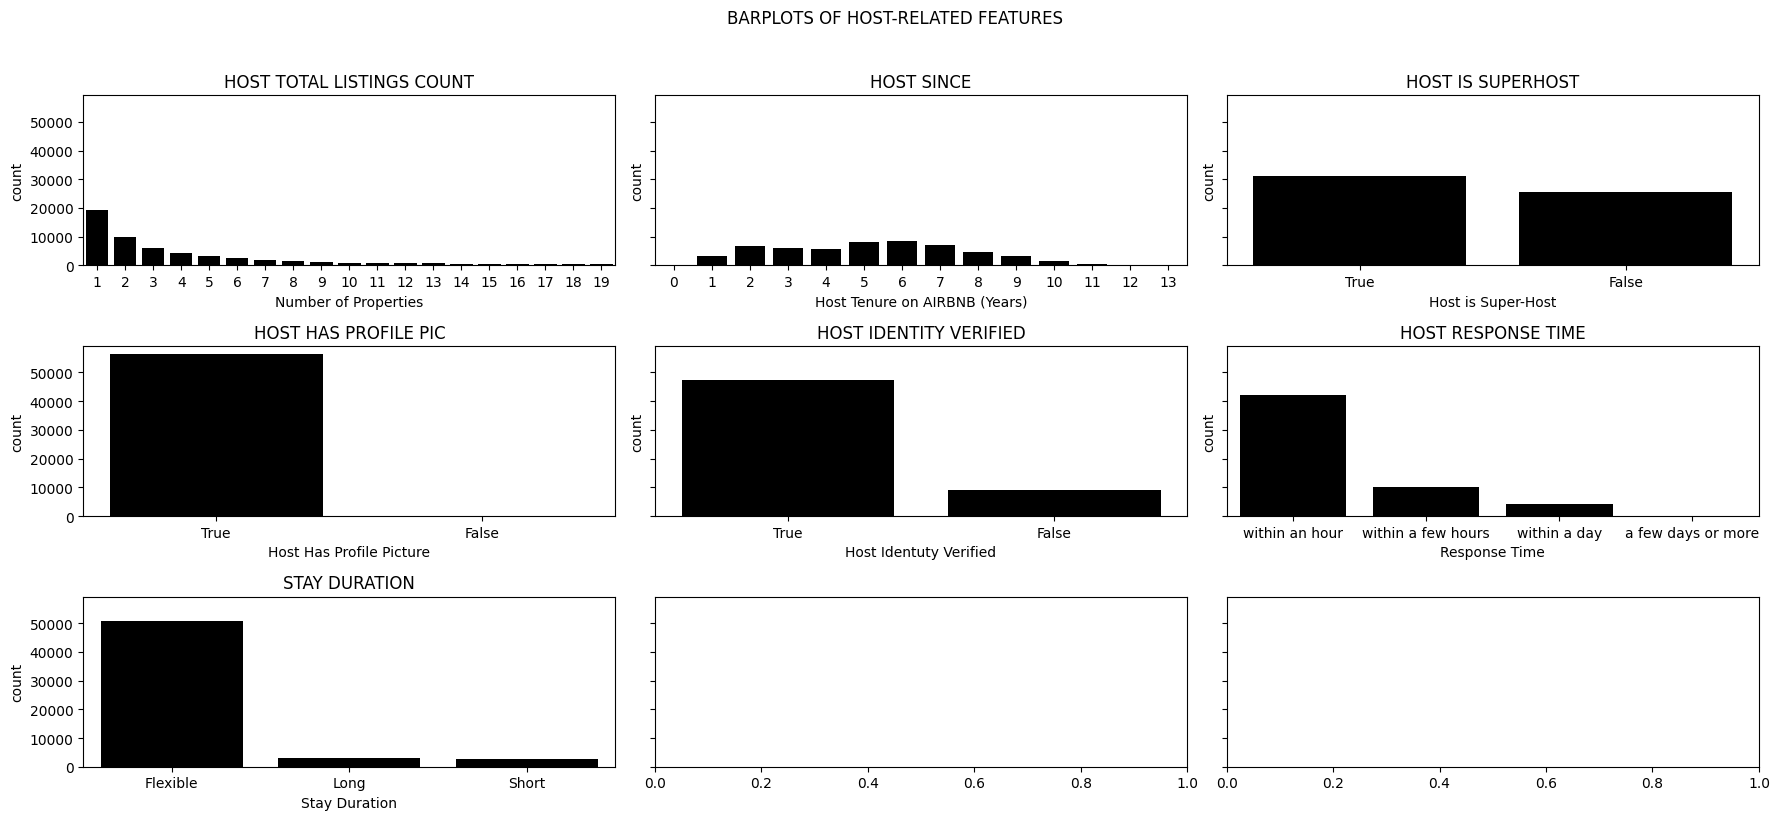

In [282]:
#@title VARIABLES (1)

ORIGINAL_DF['host_total_listings_count'] = ORIGINAL_DF['host_total_listings_count'].astype(int)
my_x_labels = ['Number of Properties','Host Tenure on AIRBNB (Years)','Host is Super-Host','Host Has Profile Picture','Host Identuty Verified', 'Response Time', 'Stay Duration']
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,8), sharey=True)
ordered_features = ['host_has_profile_pic', 'host_identity_verified', 'host_response_time', 'stay_duration']
for idx, feature in enumerate(FEATURES_DICT['CATEGORICAL FEATURES HOST'] + ['stay_duration']):
    feature_value_counts = ORIGINAL_DF[feature].value_counts().sort_index().reset_index()
    feature_value_counts.columns = [feature, 'count']
    row_idx = idx // 3  # Use 3 as the divisor
    col_idx = idx % 3   # Use 3 as the divisor
    plt.sca(axs[row_idx, col_idx])
    if feature in ordered_features:
        order = ORIGINAL_DF[feature].value_counts().index
        sns.barplot(x=feature, y='count', data=feature_value_counts, color='black', order=order)
    else:
        sns.barplot(x=feature, y='count', data=feature_value_counts, color='black')
    if feature == "city":
        plt.xticks(rotation=45, ha="right")
    plt.xlabel(my_x_labels[idx])
    plt.ylabel('count')
    plt.title(feature.replace('_', ' ').upper())
    if feature in ['host_has_profile_pic', 'host_identity_verified','host_is_superhost']:
        xtick_labels = [0, 1]  # Use numerical values
        plt.xticks(xtick_labels, ['True', 'False'])  # Set custom tick labels


fig.suptitle('Barplots of host-related features'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.6, wspace=0.4)
plt.tight_layout()
plt.show()

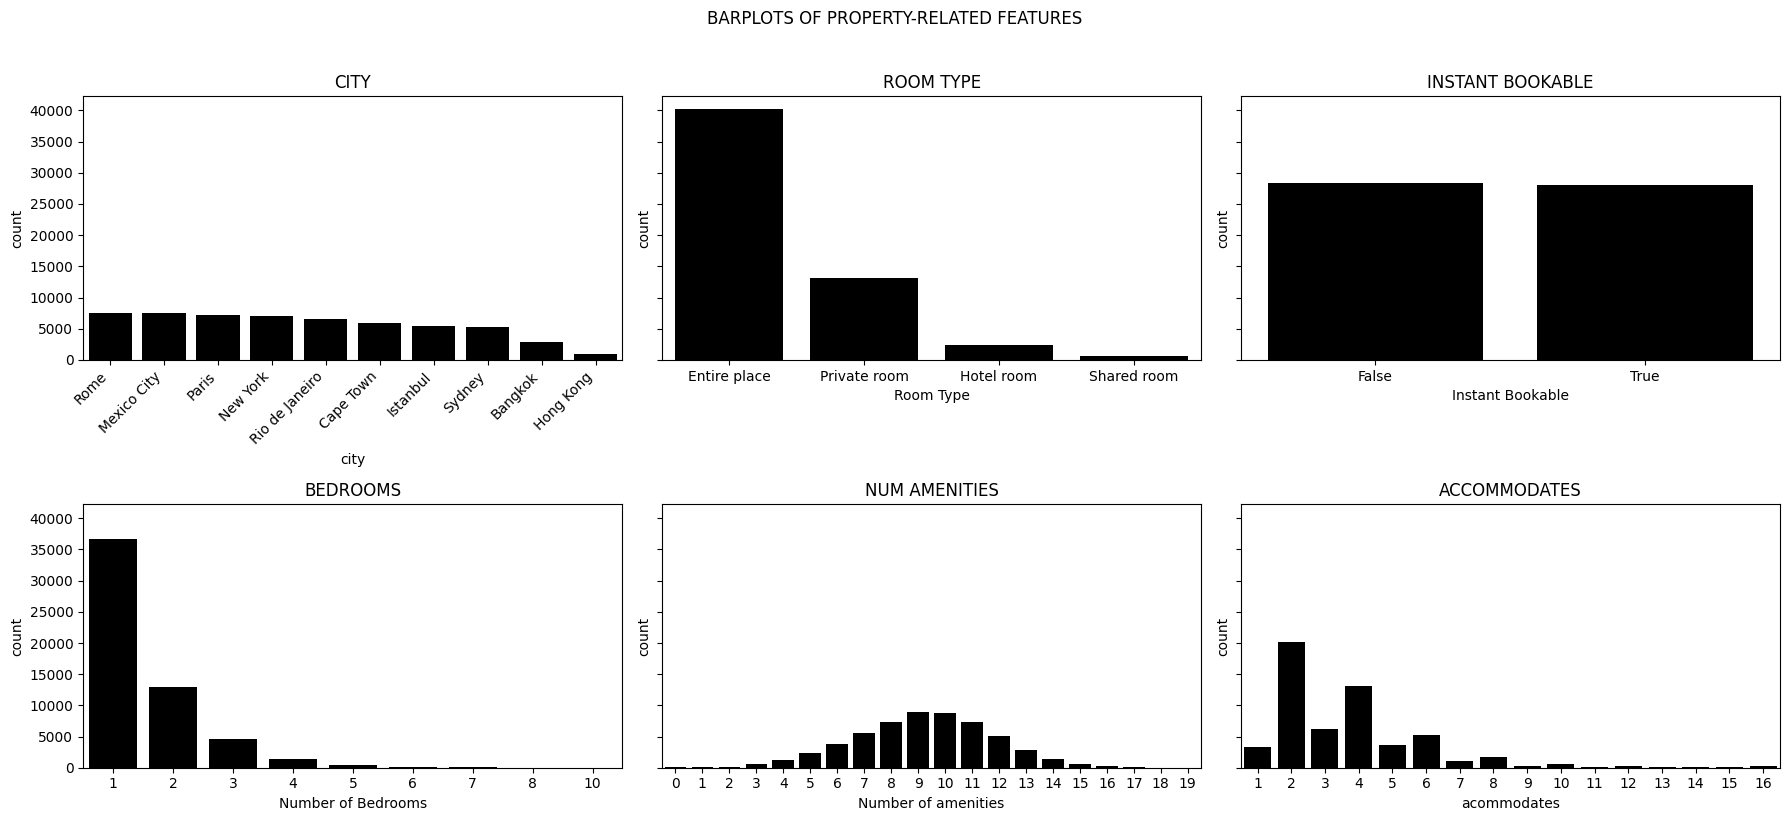

In [283]:
#@title VARIABLES (1)

ORIGINAL_DF['bedrooms'] = ORIGINAL_DF['bedrooms'].astype(int)
my_x_labels=['city','Room Type','Instant Bookable','Number of Bedrooms','Number of amenities','acommodates']

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,8), sharey=True)
ordered_features = ['city','room_type','instant_bookable']
for idx, feature in enumerate(['city','room_type','instant_bookable','bedrooms','num_amenities','accommodates']):
    feature_value_counts = ORIGINAL_DF[feature].value_counts().sort_index().reset_index()
    feature_value_counts.columns = [feature, 'count']
    row_idx = idx // 3  # Use 3 as the divisor
    col_idx = idx % 3  # Use 3 as the divisor
    plt.sca(axs[row_idx, col_idx])
    if feature in ordered_features:
        order = ORIGINAL_DF[feature].value_counts().index
        sns.barplot(x=feature, y='count', data=feature_value_counts, color='black', order=order)
    else:
        sns.barplot(x=feature, y='count', data=feature_value_counts, color='black')
    if feature == "city":
        plt.xticks(rotation=45, ha="right")
    plt.xlabel(my_x_labels[idx])
    plt.ylabel('count')
    plt.title(feature.replace('_', ' ').upper())
    if feature == 'instant_bookable':
        xtick_labels = [0, 1]  # Use numerical values
        plt.xticks(xtick_labels, ['False', 'True'])  # Set custom tick labels


fig.suptitle('Barplots of property-related features'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.6, wspace=0.4)  # Adjust the values as needed
plt.tight_layout()
plt.show()

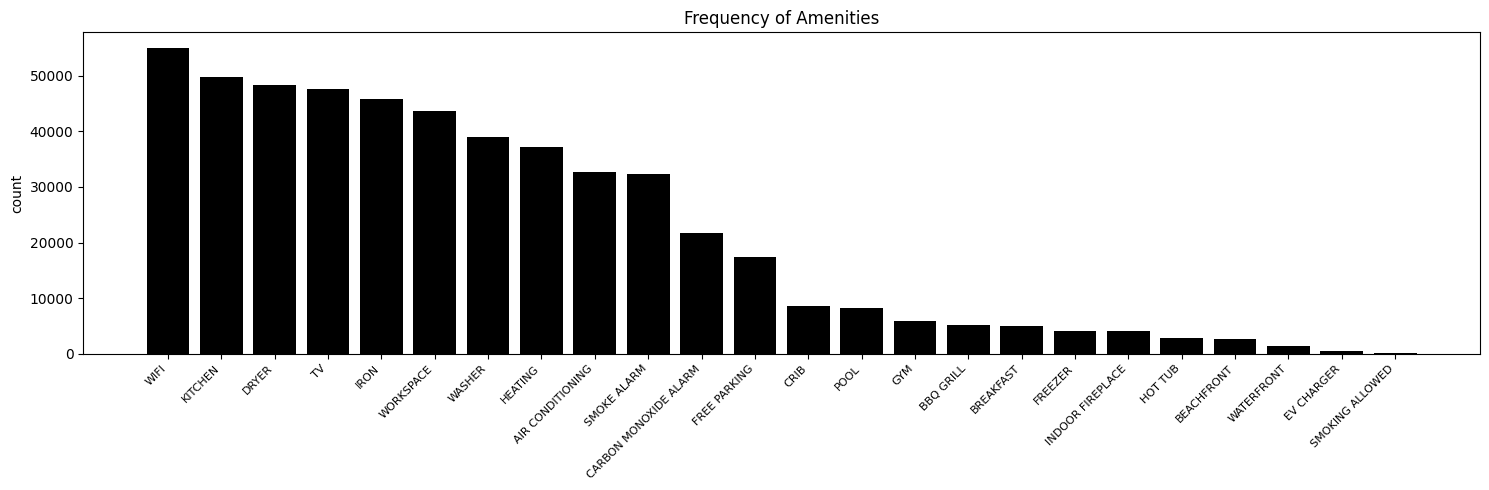

In [284]:
#@title VARIABLES (1)


plt.figure(figsize=(15,5))
plt.bar(ORIGINAL_DF[our_amenities].sum().sort_values(ascending=False).index, ORIGINAL_DF[our_amenities].sum().sort_values(ascending=False).values, color='black')
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust fontsize here
plt.ylabel('count')
plt.title('Frequency of Amenities')
plt.tight_layout()
plt.show()

several features exhibit minimal variance. The more variation there is it can be expected that if there is a correlation it will be more noticeable.

#### HOST PATTERN

We observed that in a few of the categorical features some values are frequent and some are rare. There is a factor that might be contributing to this phenomenon?

In [285]:
'There are {} different hosts out of {} listings'.format(ORIGINAL_DF['host_id'].nunique(), ORIGINAL_DF.shape[0])

'There are 33372 different hosts out of 56432 listings'

In [286]:
ORIGINAL_DF['host_id'].value_counts()[ORIGINAL_DF['host_id'].value_counts() > 1] # host with more than one listing

357701035    25
37192602     24
241327887    22
167072223    22
2435691      22
             ..
26560489      2
51227213      2
29219991      2
2256329       2
135123081     2
Name: host_id, Length: 9603, dtype: int64

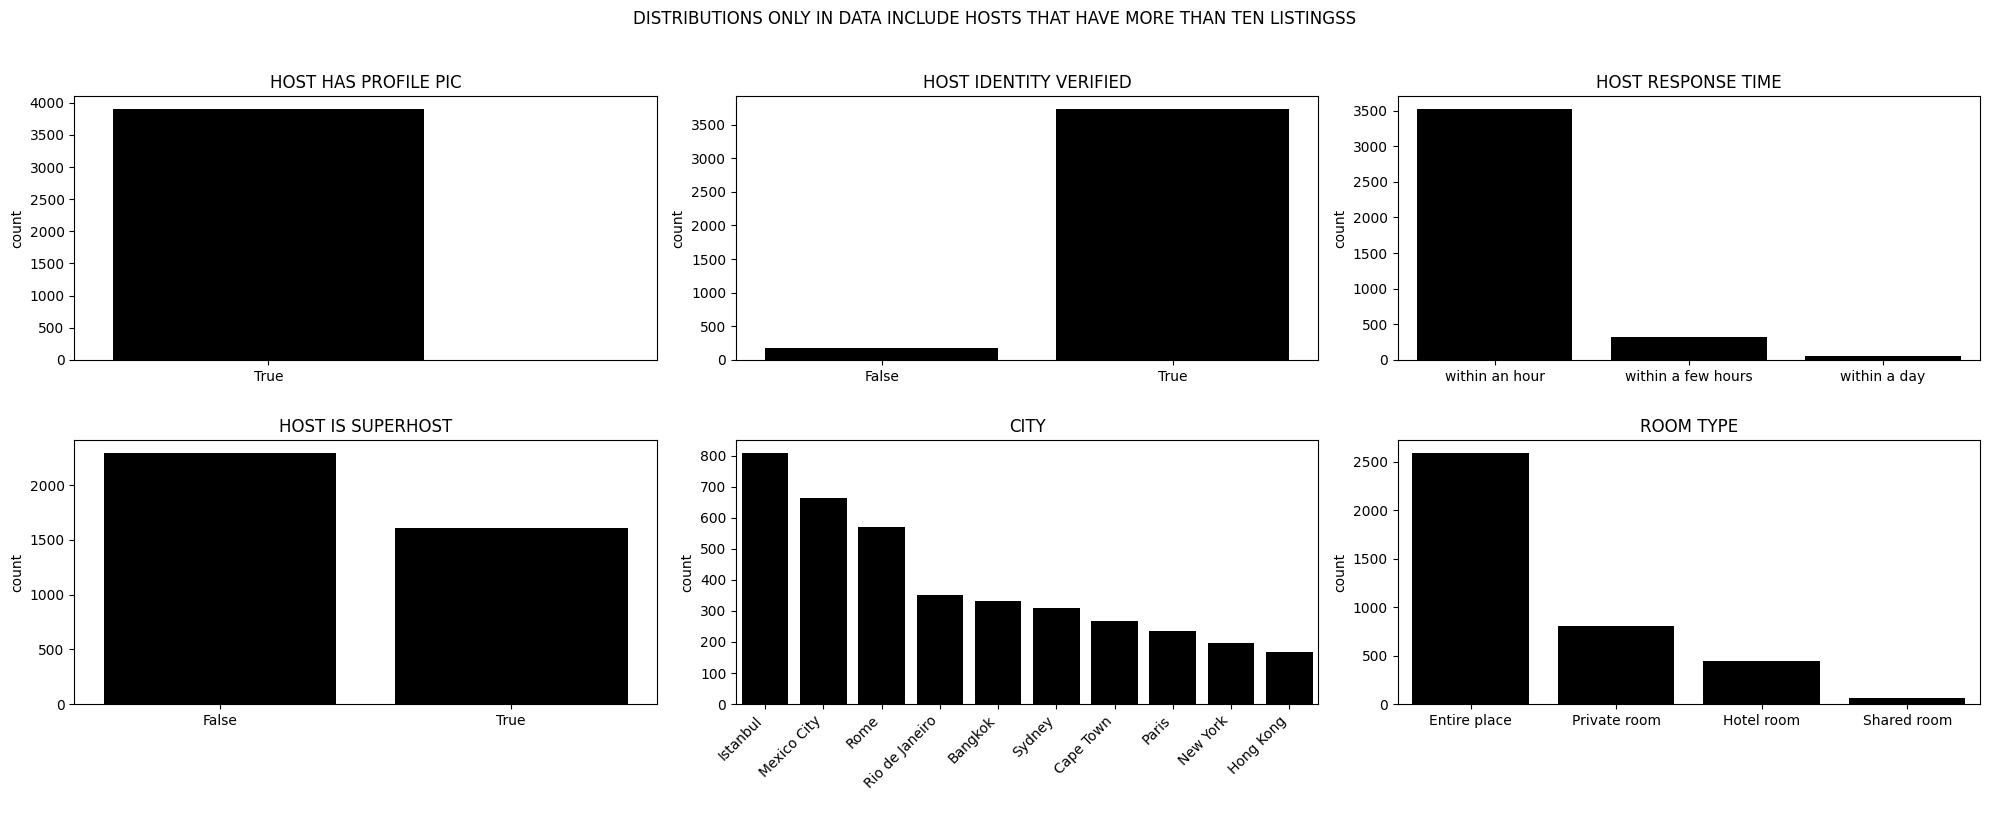

In [287]:
#@title HOST (PART 2)

MY_HOSTS = ORIGINAL_DF[ORIGINAL_DF['host_id'].isin(ORIGINAL_DF['host_id'].value_counts()[ORIGINAL_DF['host_id'].value_counts() >= 10].index)]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))
ordered_features = ['city', 'room_type', 'host_response_time']
for idx, feature in enumerate(['host_has_profile_pic', 'host_identity_verified', 'host_response_time', 'host_is_superhost', 'city', 'room_type']):
    feature_value_counts = MY_HOSTS[feature].value_counts().sort_index().reset_index()
    feature_value_counts.columns = [feature, 'count']
    row_idx = idx // 3  # Use 3 as the divisor
    col_idx = idx % 3   # Use 3 as the divisor
    plt.sca(axs[row_idx, col_idx])
    if feature in ordered_features:
        order = MY_HOSTS[feature].value_counts().index
        sns.barplot(x=feature, y='count', data=feature_value_counts, color='black', order=order)
    else:
        sns.barplot(x=feature, y='count', data=feature_value_counts, color='black')
    if feature == "city":
        plt.xticks(rotation=45, ha="right")
    plt.xlabel(' ')
    plt.ylabel('count')
    plt.title(feature.replace('_', ' ').upper())
    if feature in ['host_has_profile_pic', 'host_identity_verified','host_is_superhost']:
        xtick_labels = [0, 1]
        plt.xticks(xtick_labels, ['False', 'True'])
        if feature == 'host_has_profile_pic':
          xtick_labels = [0]
          plt.xticks(xtick_labels, ['True'])

fig.suptitle('Distributions only in data include hosts that have more than ten listingss'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)  # Adjust the values as needed
plt.tight_layout()
plt.show()

Distributions among the various categories is the same as the distributions of all the data so it does not appear that hosts with more than one listing cause an imbalance between the categories.

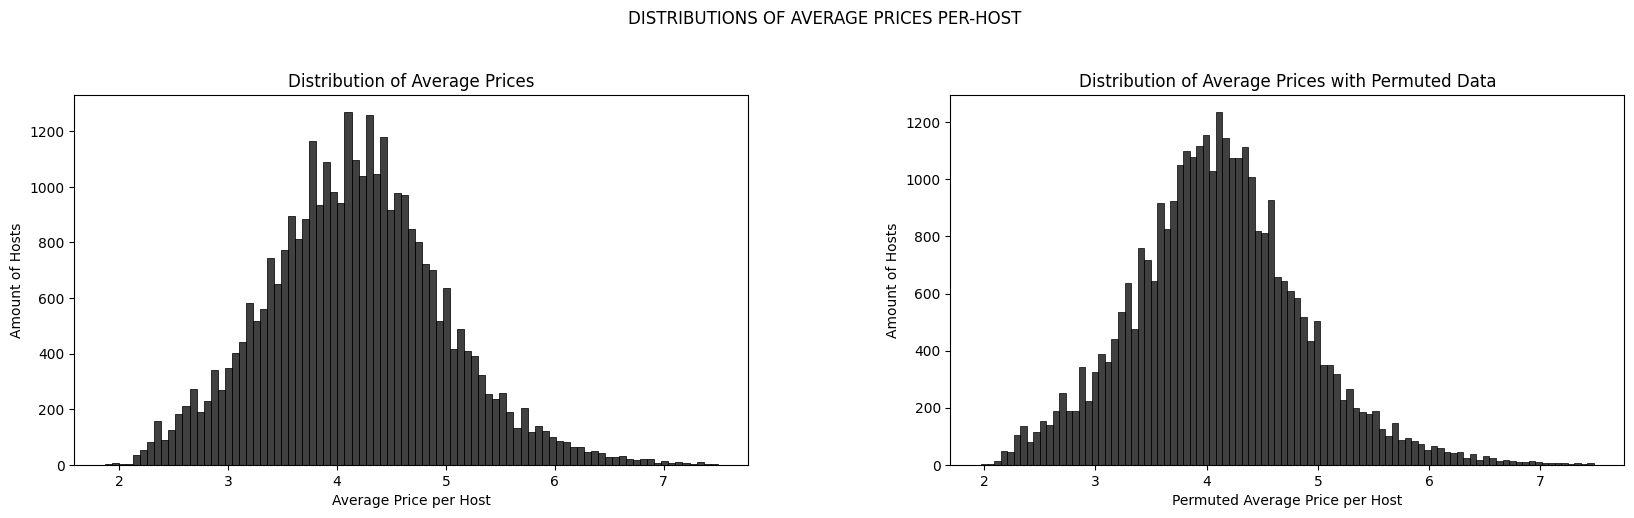

In [288]:
#@title HOST (PART 2)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))

plt.sca(axs[0])
host_pricing = ORIGINAL_DF.groupby('host_id')[['price_log']].agg('mean')
sns.histplot(x = 'price_log', data = host_pricing, color='black')
plt.xlabel('Average Price per Host')
plt.ylabel('Amount of Hosts')
plt.title('Distribution of Average Prices')

plt.sca(axs[1])
perm = ORIGINAL_DF.copy()
perm['host_id'] = perm['host_id'].sample(frac=1, ignore_index=True)
perm = perm.groupby('host_id')[['price_log']].agg('mean')
sns.histplot(x='price_log', data=perm, color='black')
plt.xlabel('Permuted Average Price per Host')
plt.ylabel('Amount of Hosts')
plt.title('Distribution of Average Prices with Permuted Data')

fig.suptitle('Distributions of Average Prices per-host'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)  # Adjust the values as needed

SD is wide but no wider than we would expect BY CHANCE. Different hosts do not seem to tend to give different prices.

In [289]:
#@title HOST (PART 2)

print('Average price std {}'.format(host_pricing.std().round(2).item()), 'Permuted Average price std {}'.format(perm.std().round(2).item()))

Average price std 0.81 Permuted Average price std 0.76


In [290]:
#@title HOST (PART 2)

ORIGINAL_DF = ORIGINAL_DF.drop(columns = 'host_id')

#### CORRELATIONS

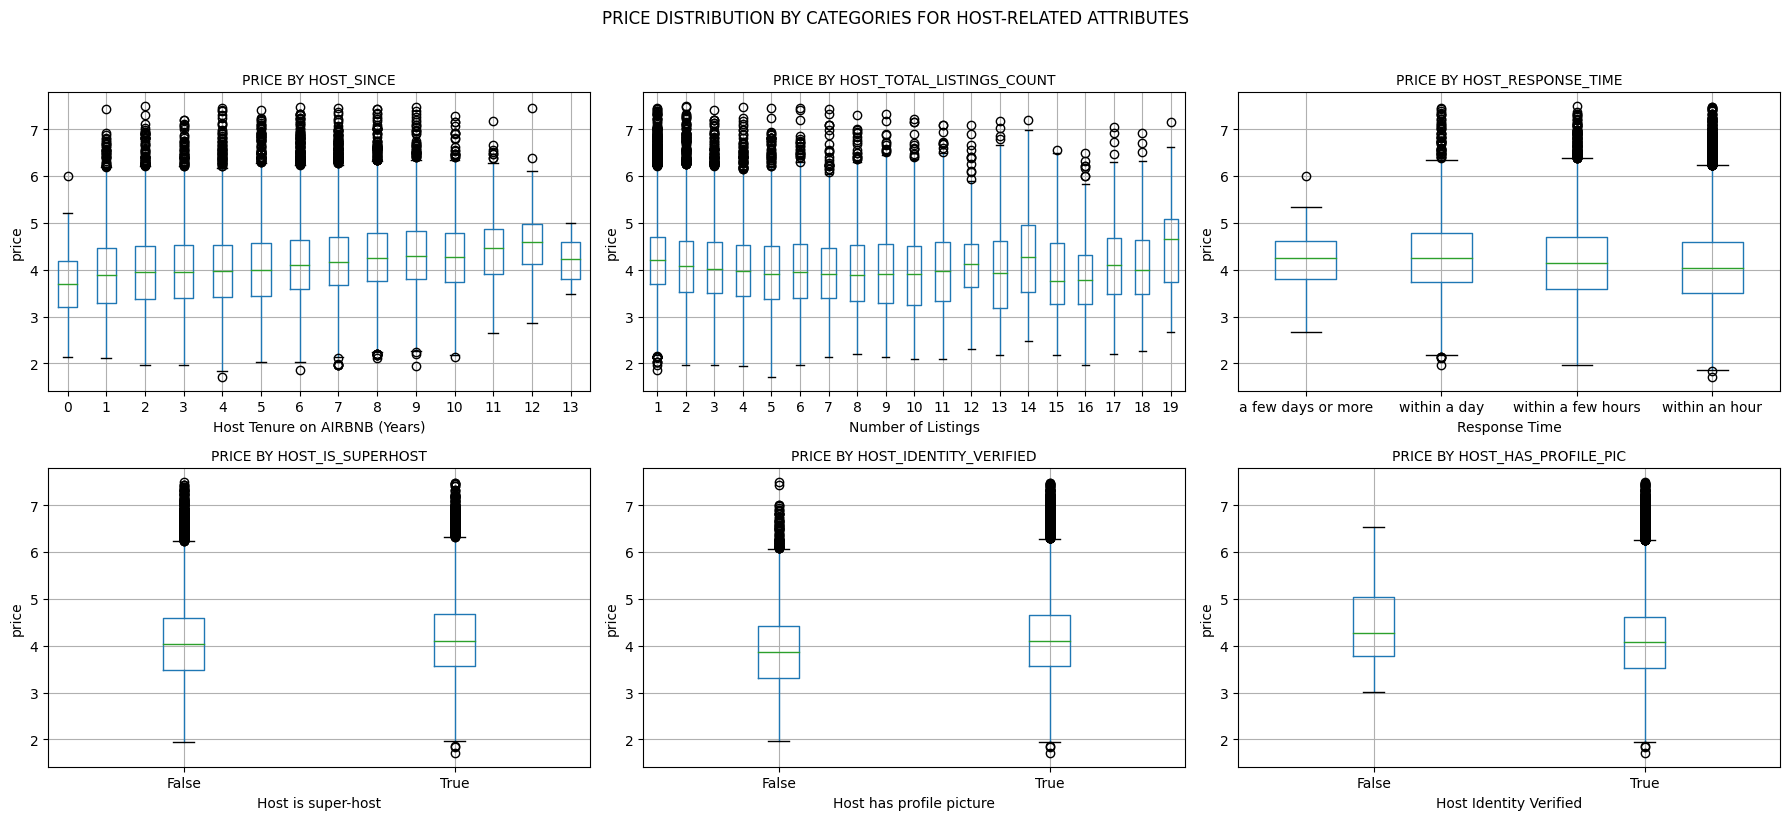

In [291]:
#@title TARGET PRICE

fig, axs = plt.subplots(2, 3, figsize = (18,8))

my_xlabels= ['Host Tenure on AIRBNB (Years)','Number of Listings','Response Time','Host is super-host', 'Host has profile picture','Host Identity Verified']
for i, feature in enumerate(['host_since', 'host_total_listings_count','host_response_time','host_is_superhost','host_identity_verified','host_has_profile_pic']):
    row, col = i // 3, i % 3
    boxplot = ORIGINAL_DF[[feature, 'price_log']].boxplot(by = feature, ax = axs[row, col])
    if feature in ['host_is_superhost','host_identity_verified','host_has_profile_pic']:
       xtick_labels = ['False', 'True']
       boxplot.set_xticklabels(xtick_labels)
    axs[row, col].set_title(f'price by {feature}'.upper(), fontsize=10)
    axs[row, col].set_xlabel(my_xlabels[i])
    axs[row, col].set_ylabel('price')

fig.suptitle('Price Distribution by Categories for Host-related attributes'.upper(),y=1.02, fontsize=12)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)  # Adjust the values as needed
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

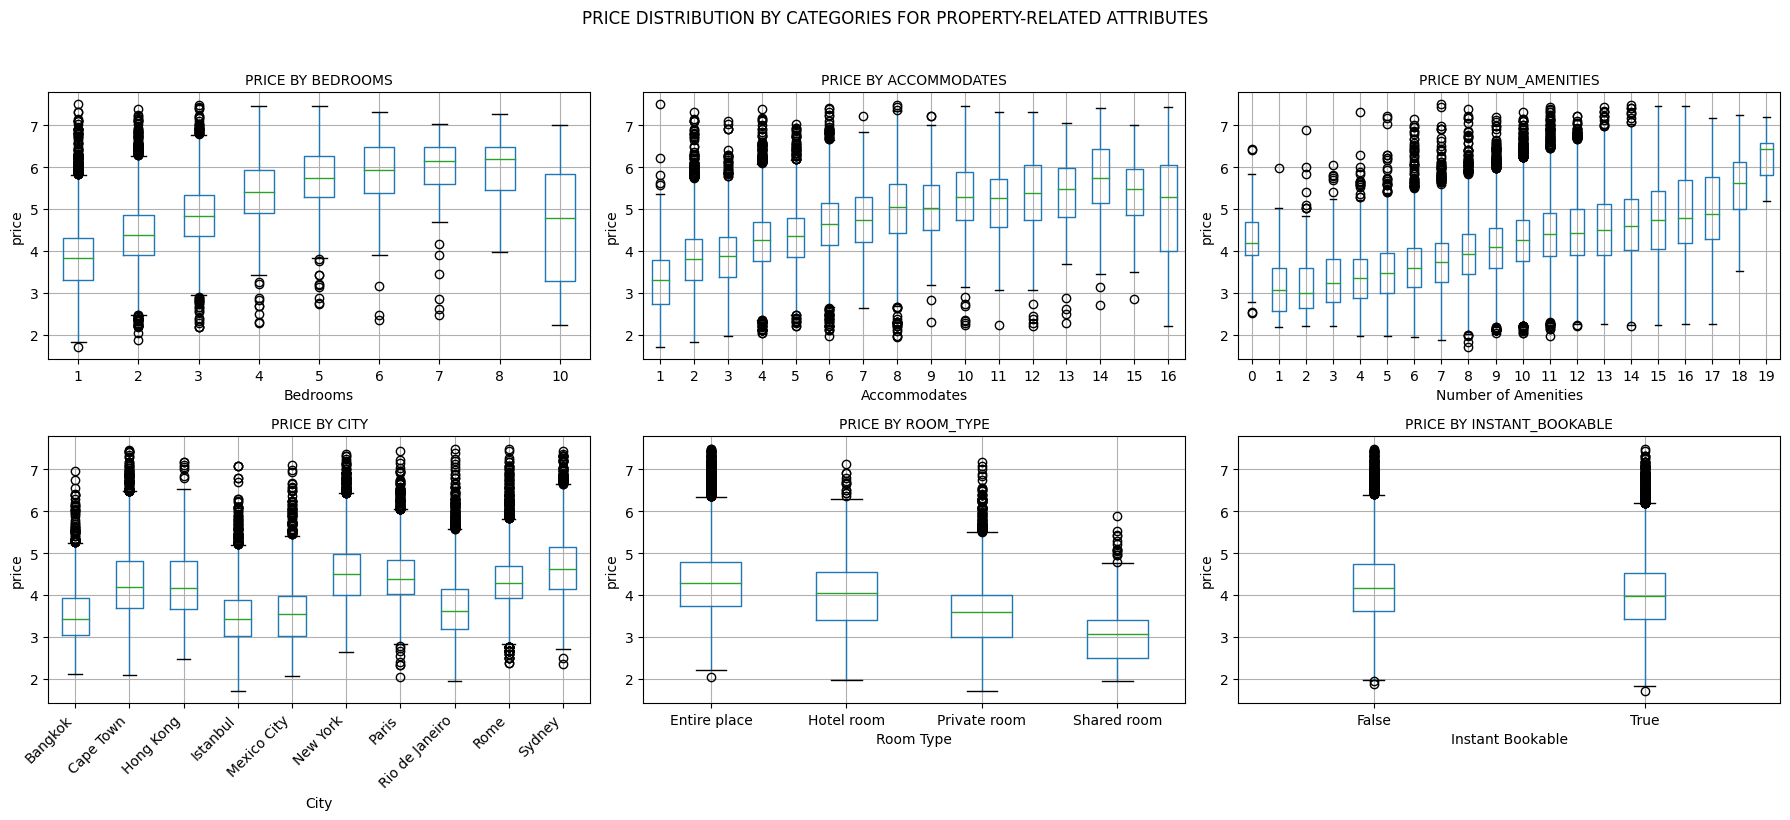

In [292]:
#@title TARGET PRICE

# Selected features
corr = ['bedrooms','accommodates','num_amenities','city', 'room_type','instant_bookable']
my_xlabels = ['Bedrooms','Accommodates','Number of Amenities','City','Room Type','Instant Bookable']

# Create the subplot grid
fig, axs = plt.subplots(2, 3, figsize = (18,8))

for i, feature in enumerate(corr):
    row, col = i // 3, i % 3
    boxplot = ORIGINAL_DF[[feature, 'price_log']].boxplot(by = feature, ax = axs[row, col])
    if feature == 'instant_bookable':
       xtick_labels = ['False', 'True']
       boxplot.set_xticklabels(xtick_labels)
    axs[row, col].set_title(f'price by {feature}'.upper(), fontsize=10)
    axs[row, col].set_xlabel(my_xlabels[i])
    axs[row, col].set_ylabel('price')
    if feature == 'city':
        axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Price Distribution by Categories for Property-related attributes'.upper(),y=1.02, fontsize=12)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)  # Adjust the values as needed
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

In [293]:
#@title TARGET PRICE

corr_with_target = ORIGINAL_DF[['host_since','accommodates', 'bedrooms', 'num_amenities']].corrwith(ORIGINAL_DF['price_log'], method='pearson').round(3).reset_index().rename(columns = {'index' : 'feature', 0 : 'pearson_correlation_with_target'}).sort_values(by = 'pearson_correlation_with_target', ascending = False).reset_index(drop=True)
corr_with_target

,feature,pearson_correlation_with_target
0,bedrooms,0.511
1,accommodates,0.488
2,num_amenities,0.408
3,host_since,0.154


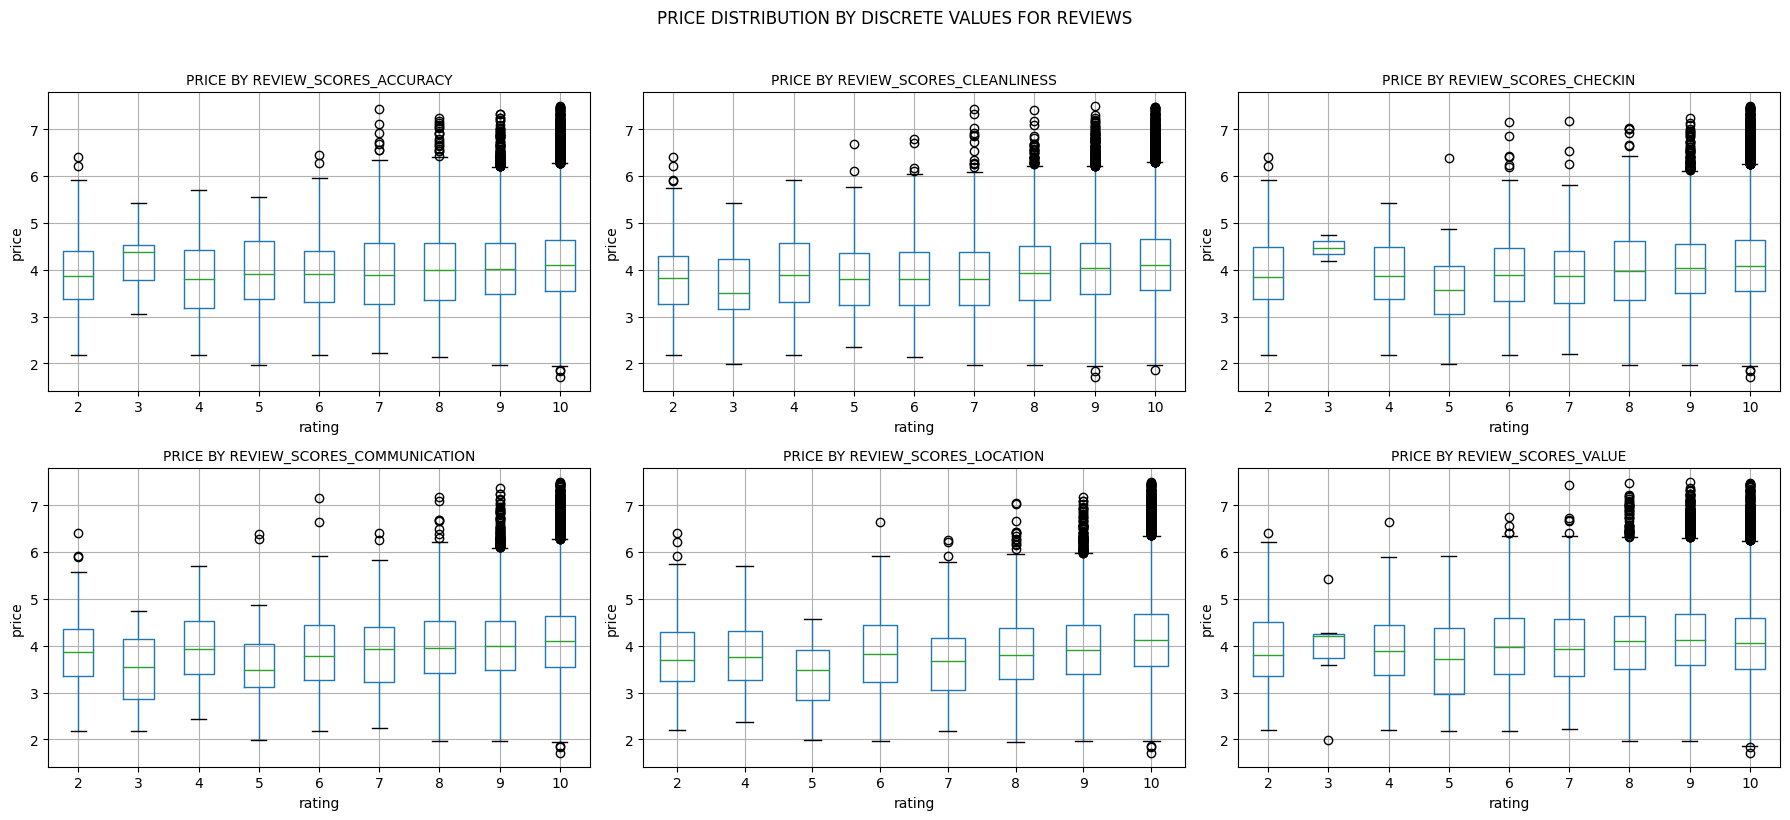

In [294]:
#@title TARGET PRICE

fig, axs = plt.subplots(2, 3, figsize = (18,8))

for i, feature in enumerate(FEATURES_DICT['SPECIFIC REVIEWS']):
    ORIGINAL_DF[feature] = ORIGINAL_DF[feature].astype(int)
    row, col = i // 3, i % 3
    ORIGINAL_DF[[feature, 'price_log']].boxplot(by = feature, ax = axs[row, col])
    axs[row, col].set_title(f'Price by {feature}'.upper(), fontsize=10)
    axs[row, col].set_xlabel('rating')
    axs[row, col].set_ylabel('price')

fig.suptitle('Price Distribution by discrete values for reviews'.upper(), y=1.02, fontsize=12)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)  # Adjust the values as needed
plt.tight_layout()
plt.show()

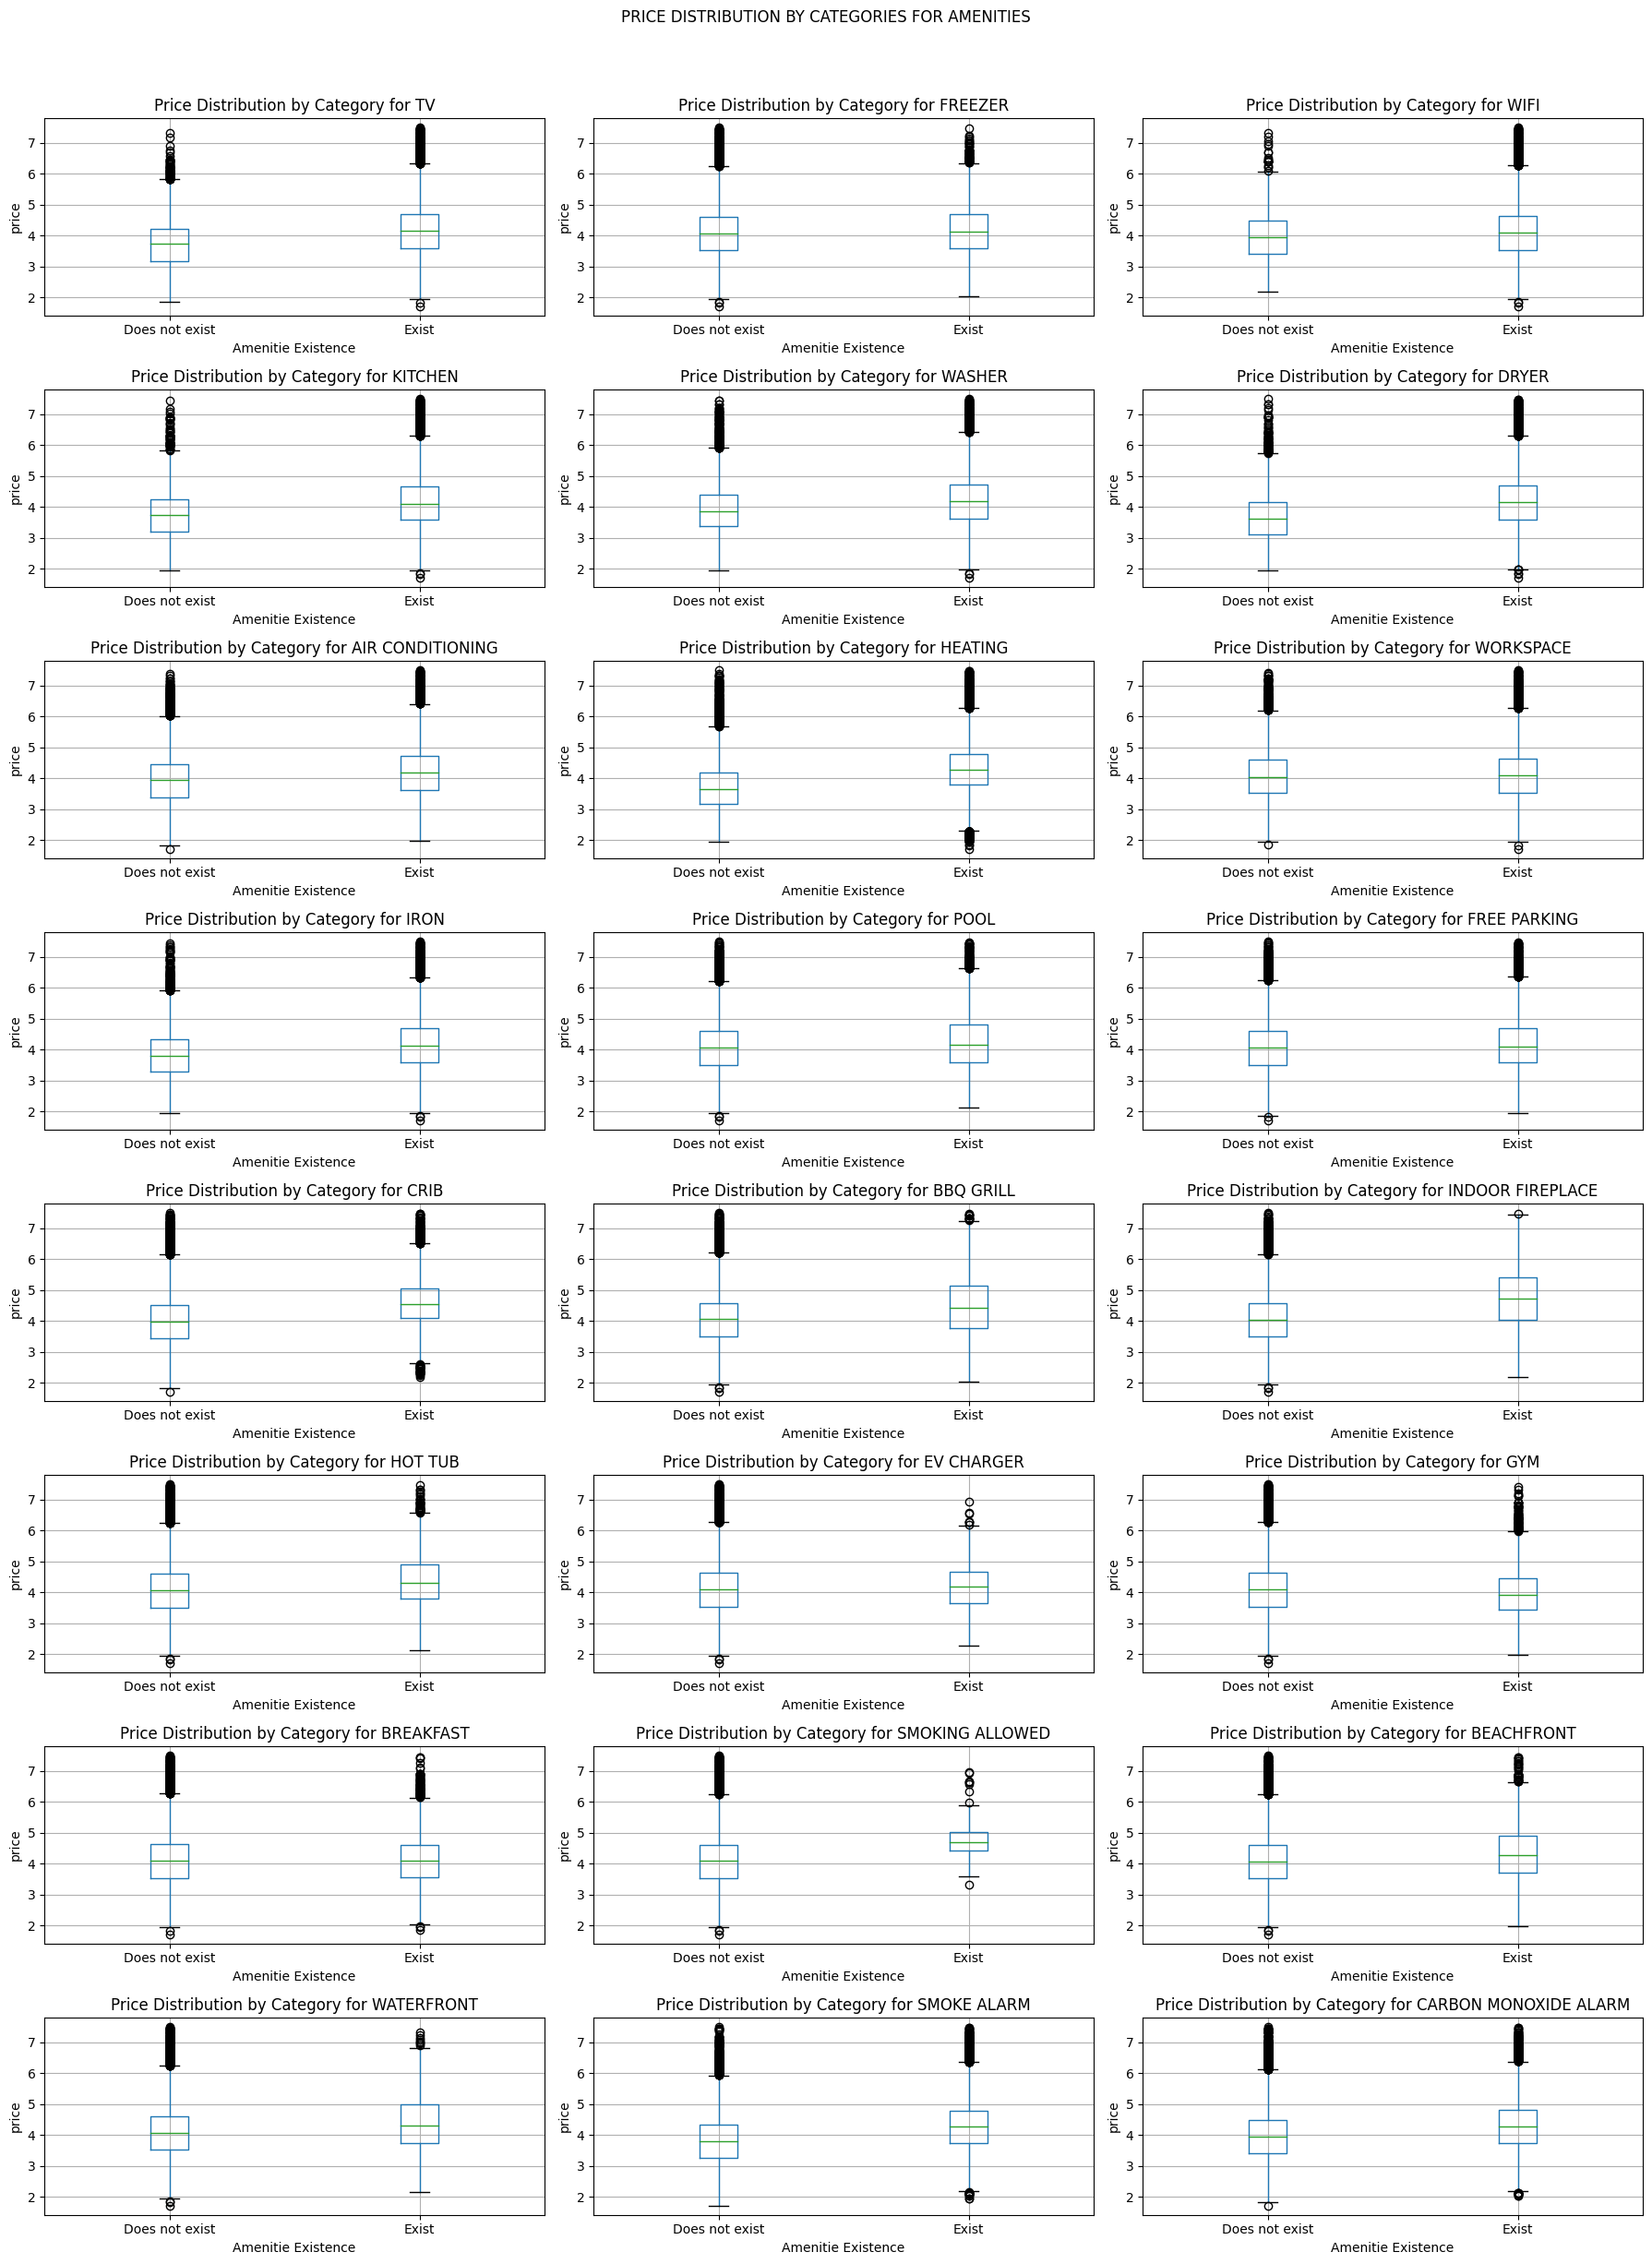

In [295]:
#@title TARGET PRICE

fig, axs = plt.subplots(8, 3, figsize=(18, 24))  # Adjust the number of rows and columns

for i, feature in enumerate(FEATURES_DICT['AMENITIES']):
    row, col = i // 3, i % 3
    boxplot = ORIGINAL_DF[[feature, 'price_log']].boxplot(by=feature, ax=axs[row, col])

    # Change x-axis labels
    xtick_labels = ['Does not exist', 'Exist']
    boxplot.set_xticklabels(xtick_labels)

    axs[row, col].set_title(f'Price Distribution by Category for {feature}')
    axs[row, col].set_xlabel('Amenitie Existence')
    axs[row, col].set_ylabel('price')

fig.suptitle('Price Distribution by Categories for Amenities'.upper(), y=1.02)
plt.subplots_adjust(top=0.85, hspace=0.5, wspace=0.3)  # Adjust the values as needed
plt.tight_layout()  # Adjust spacing between subplots
plt.show()

#### FOLLOWING CORRELATIONS

The price demonstrates a subtle decrease when the guest count reaches 16. What might be contributing to this phenomenon?

<Figure size 2000x500 with 0 Axes>

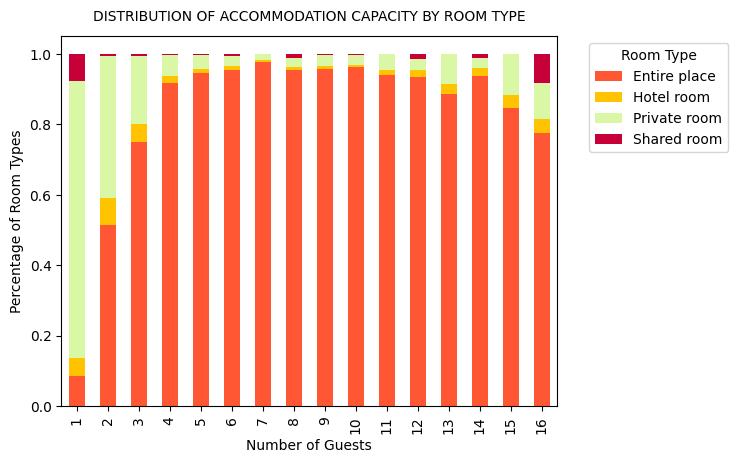

In [296]:
#@title FOLLOWING IT

pivot_p = pd.DataFrame(ORIGINAL_DF.groupby('accommodates')['room_type'].value_counts(normalize=True)).rename(columns={'room_type': 'percentage'}).reset_index().pivot(index='accommodates', columns='room_type', values='percentage')

plt.figure(figsize=(20, 5))
pivot_p.plot(kind='bar', stacked=True, color=['#FF5733', '#FFC300', '#DAF7A6', '#C70039'])
plt.xlabel('Number of Guests')
plt.ylabel('Percentage of Room Types')
plt.title('Distribution of Accommodation Capacity by Room Type'.upper(), fontsize=10,y=1.02)
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Which properties have no services offered yet their prices are unexpectedly higher even before the usual trend of a correlation between the number of services offered and the price comes into play?

<Figure size 2000x500 with 0 Axes>

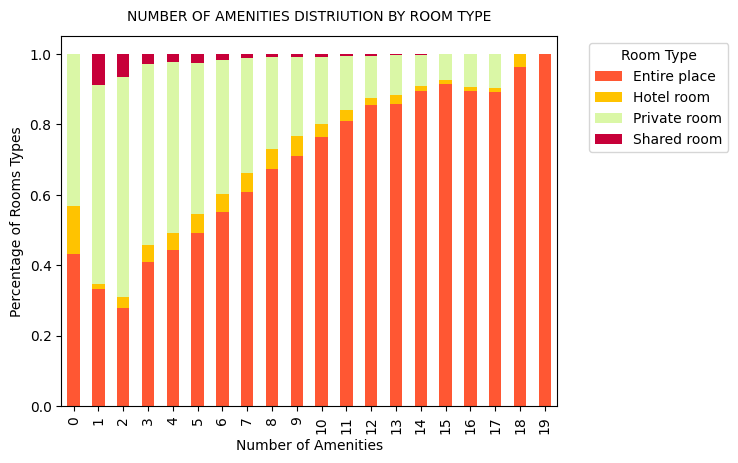

In [297]:
#@title FOLLOWING IT

# Plot the first subplot (City Distribution by Number of Amenities)
pivot_city = pd.DataFrame(ORIGINAL_DF.groupby('num_amenities')['room_type'].value_counts(normalize=True)).rename(columns={'room_type': 'percentage'}).reset_index().pivot(index='num_amenities', columns='room_type', values='percentage')
plt.figure(figsize=(20, 5))
pivot_city.plot(kind='bar', stacked=True,color=['#FF5733', '#FFC300', '#DAF7A6', '#C70039'])
plt.xlabel('Number of Amenities')
plt.ylabel('Percentage of Rooms Types')
plt.title('Number of Amenities Distriution by Room Type'.upper(), fontsize=10, y=1.02)
plt.legend(title='Room Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### CORRELATIONS

As evident from prior part and apparent even with a rudimentary understanding of the variables there exist correlations among the independent variables present in the dataset. Let's delve further into investigating this phenomenon. This awareness is important because it helps anticipate potential multi-col-linearity issues.

In [298]:
#@title LET'S CHECK THE REVIEWS!

ORIGINAL_DF[FEATURES_DICT['REVIEWS']].corr(method='pearson').style.background_gradient(cmap = 'coolwarm').set_precision(2) # We would expect to see high correlations between all reviews

<ipython-input-298-efe09b160711>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  ORIGINAL_DF[FEATURES_DICT['REVIEWS']].corr(method='pearson').style.background_gradient(cmap = 'coolwarm').set_precision(2) # We would expect to see high correlations between all reviews


,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
review_scores_rating,1.00,0.77,0.72,0.62,0.68,0.50,0.75
review_scores_accuracy,0.77,1.00,0.62,0.63,0.65,0.49,0.68
review_scores_cleanliness,0.72,0.62,1.00,0.50,0.52,0.40,0.62
review_scores_checkin,0.62,0.63,0.50,1.00,0.69,0.47,0.54
review_scores_communication,0.68,0.65,0.52,0.69,1.00,0.47,0.58
review_scores_location,0.50,0.49,0.40,0.47,0.47,1.00,0.48
review_scores_value,0.75,0.68,0.62,0.54,0.58,0.48,1.00


In [299]:
#@title HOST RELATED-ATTRIBUTES

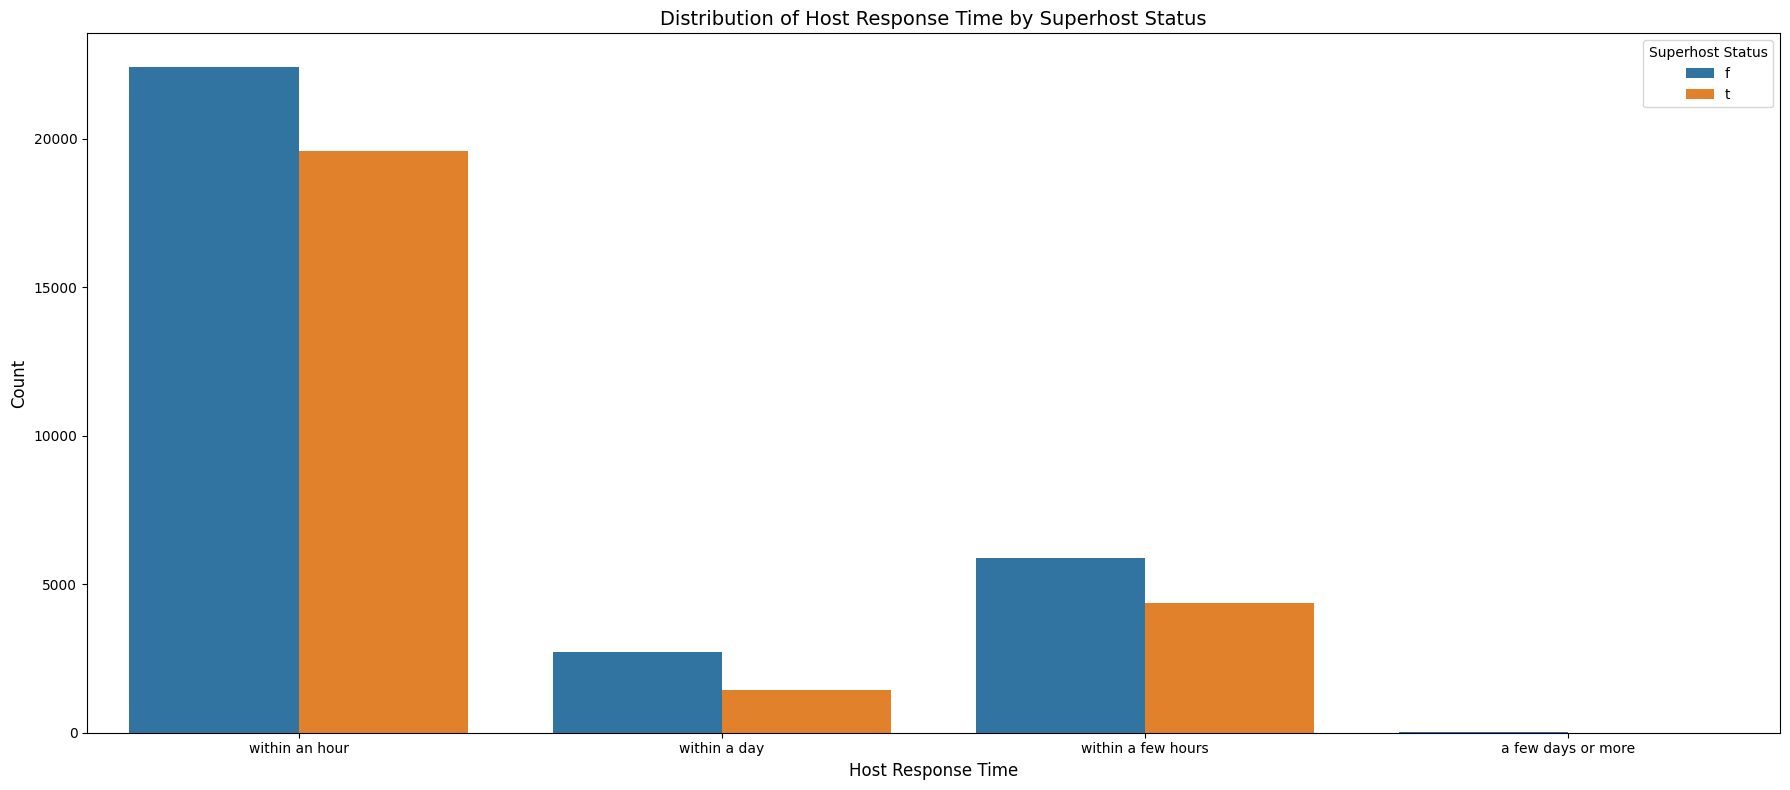

In [300]:
#@title  HOST RELATED-ATTRIBUTES

plt.figure(figsize=(18, 8))
sns.countplot(x='host_response_time', hue='host_is_superhost', data=ORIGINAL_DF)

plt.xlabel('Host Response Time', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Host Response Time by Superhost Status', fontsize=14)
plt.legend(title='Superhost Status')
plt.tight_layout()
plt.show()

In [301]:
#@title PROPERTY ATTRIBUTES

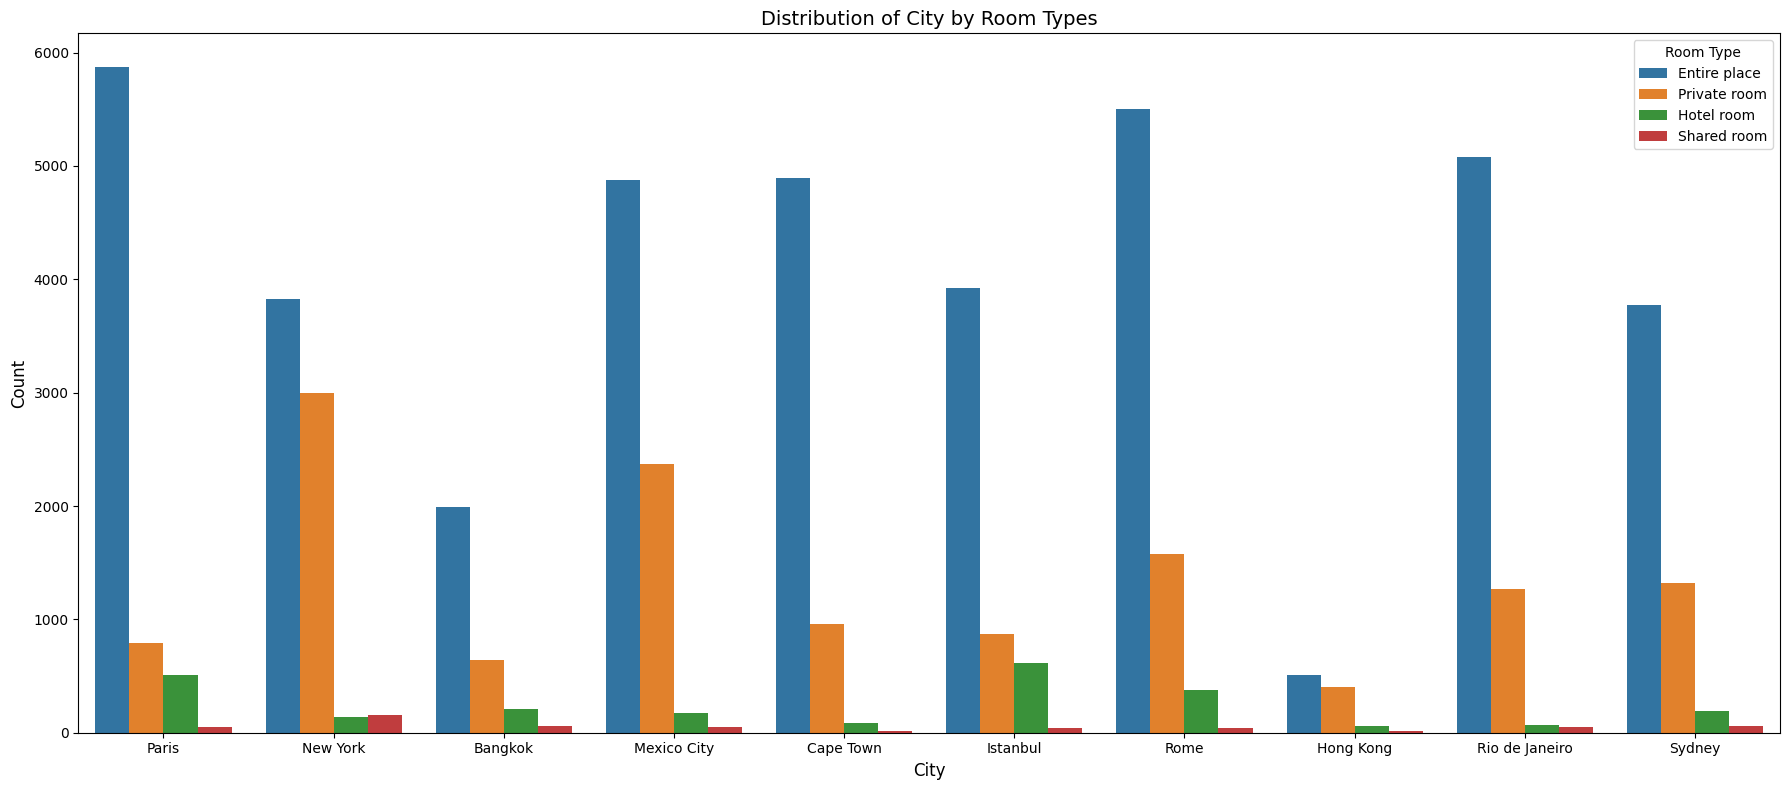

In [302]:
#@title PROPERTY ATTRIBUTES

plt.figure(figsize=(18, 8))
sns.countplot(x='city', hue='room_type', data=ORIGINAL_DF)

plt.xlabel('City', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of City by Room Types', fontsize=14)
plt.legend(title='Room Type')

plt.tight_layout()
plt.show()

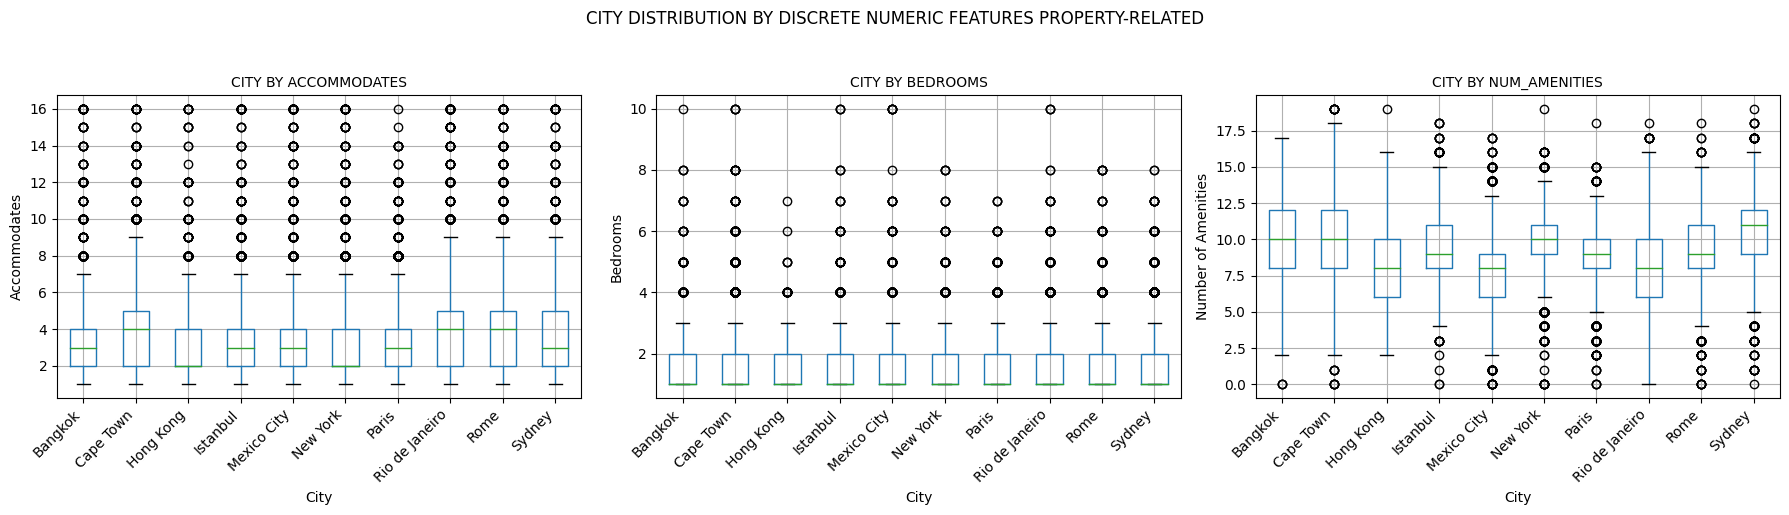

In [303]:
#@title PROPERTY ATTRIBUTES

my_ylabels = ['Accommodates', 'Bedrooms', 'Number of Amenities']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(['accommodates', 'bedrooms', 'num_amenities']):
    row, col = 0, i
    ORIGINAL_DF.boxplot(column=feature, by='city', ax=axs[col])
    axs[col].set_title(f'city by {feature}'.upper(), fontsize=10)
    axs[col].set_xlabel('City')
    axs[col].set_ylabel(my_ylabels[i])
    axs[col].set_xticklabels(axs[col].get_xticklabels(), rotation=45, ha='right')

fig.suptitle('city Distribution by Discrete Numeric Features Property-related'.upper(), y=1.02, fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust title position
plt.show()

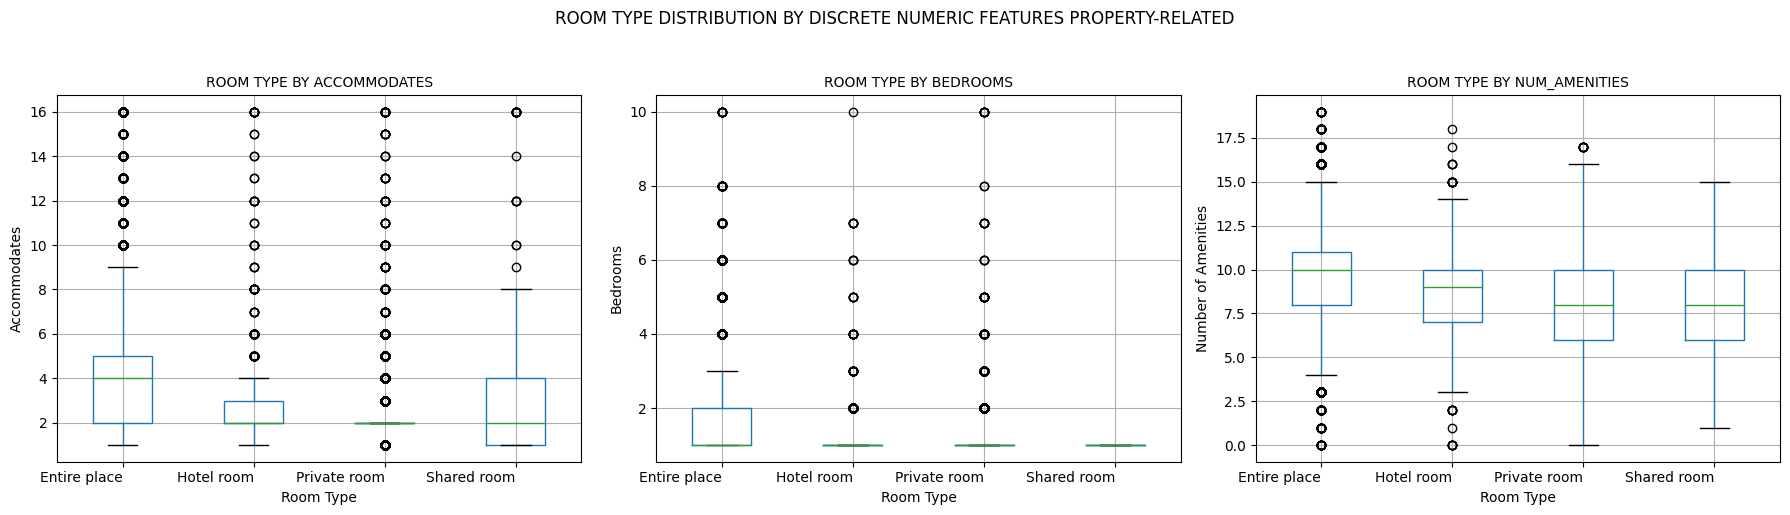

In [304]:
#@title PROPERTY ATTRIBUTES

my_ylabels = ['Accommodates', 'Bedrooms', 'Number of Amenities']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(['accommodates', 'bedrooms', 'num_amenities']):
    row, col = 0, i
    ORIGINAL_DF.boxplot(column=feature, by='room_type', ax=axs[col])
    axs[col].set_title(f'Room Type by {feature}'.upper(), fontsize=10)
    axs[col].set_xlabel('Room Type')
    axs[col].set_ylabel(my_ylabels[i])
    axs[col].set_xticklabels(axs[col].get_xticklabels(), ha='right')

fig.suptitle('Room Type Distribution by Discrete Numeric Features Property-related'.upper(), y=1.02, fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust title position
plt.show()

A consistent trend emerges in this context as well. As the number of individuals requiring accommodation increase there is a propensity for individuals to opt for both entire spaces and shared rooms.

## ALGORITHM


Let's use the **SILLHOUETTE SCORE** index to fine-tune the **K PARAMETER** as well as make meaningful comparisons between various models.

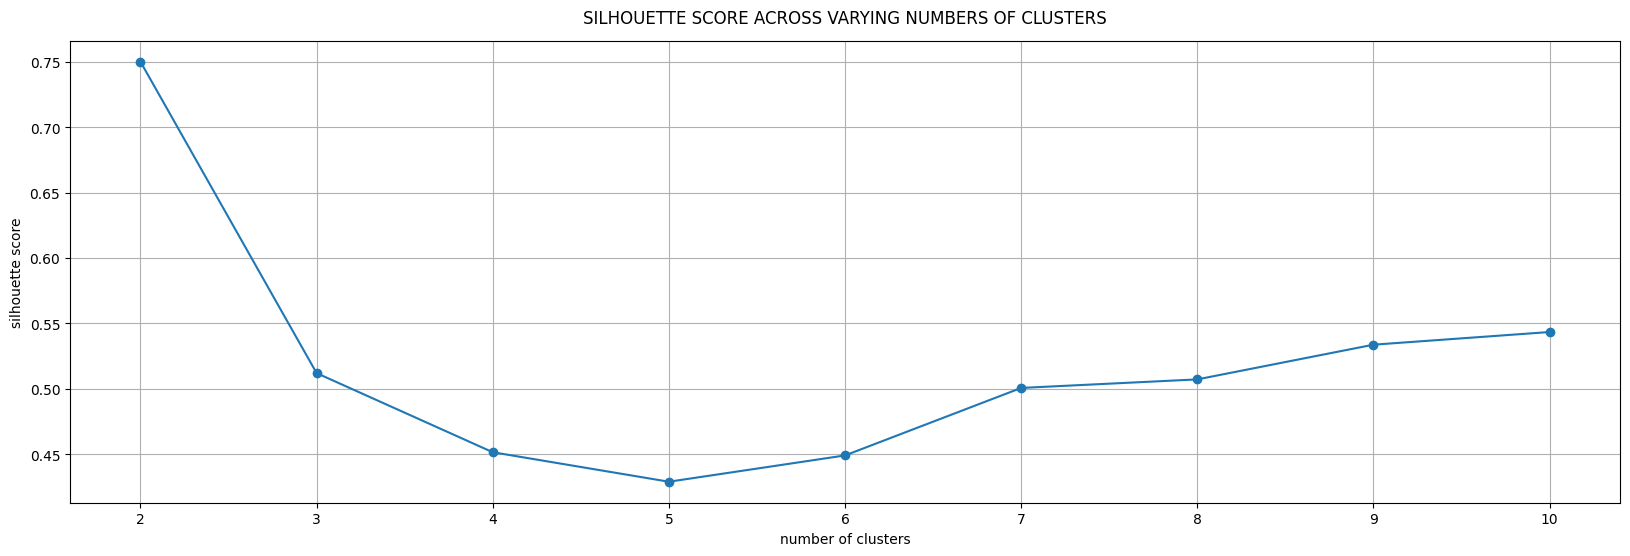

In [305]:
#@title ALGORITHM (1)

ORIGINAL_DF_KMEANS = ORIGINAL_DF.set_index('city')[FEATURES_DICT['SPECIFIC REVIEWS']]

np.random.seed(1)
scores = {}
for n_clusters in range(2,11):
  kmeans = KMeans(n_clusters, n_init = 10)
  kmeans.fit(ORIGINAL_DF_KMEANS)
  scores[n_clusters] = silhouette_score(ORIGINAL_DF_KMEANS, kmeans.labels_)

plt.figure(figsize=(20,6))
plt.plot(list(scores.keys()), list(scores.values()), "-o")
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('Silhouette Score Across Varying Numbers of Clusters'.upper(), y=1.02)
plt.grid(True)
plt.show()

In [306]:
CHOSEN_K = 2

In [307]:
#@title RUN KMEANS

np.random.seed(1)
kmeans = KMeans(2, n_init=10)
kmeans.fit(ORIGINAL_DF_KMEANS);

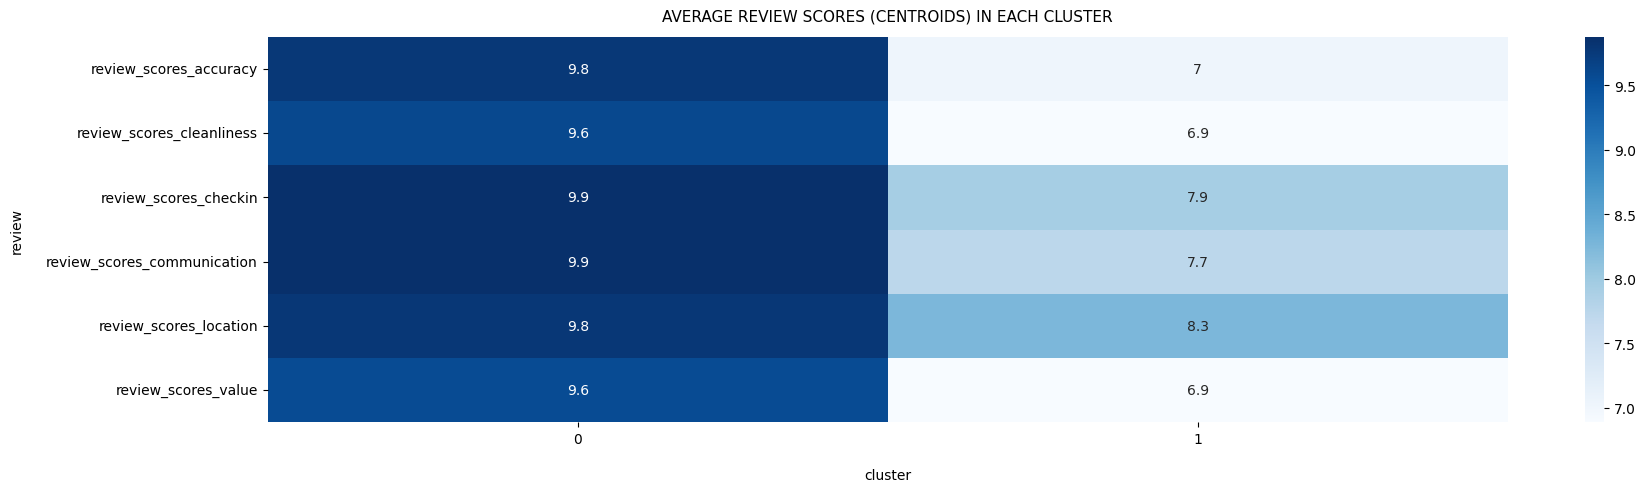

In [308]:
#@title CLUSTERS RES

ORIGINAL_DF_KMEANS['cluster'] = kmeans.labels_
df = ORIGINAL_DF_KMEANS.groupby('cluster').mean().round(3).reset_index()
plt.figure(figsize=(20,5))
heatmap = sns.heatmap(df.drop('cluster', axis=1).transpose(), cmap='Blues', annot=True)
heatmap.set_xlabel('cluster', labelpad=16)
heatmap.set_ylabel('review', labelpad=16)
heatmap.set_title('Average Review Scores (centroids) in Each Cluster'.upper(), fontsize=11, y=1.02)
plt.show()

In [309]:
#@title CENTERS RES

print('cluster 0 centers {} cluster 1 centers {}'.format(kmeans.cluster_centers_[0].round(3), kmeans.cluster_centers_[1].round(3)))

cluster 0 centers [9.776 9.595 9.874 9.874 9.781 9.563] cluster 1 centers [7.034 6.889 7.935 7.739 8.256 6.894]


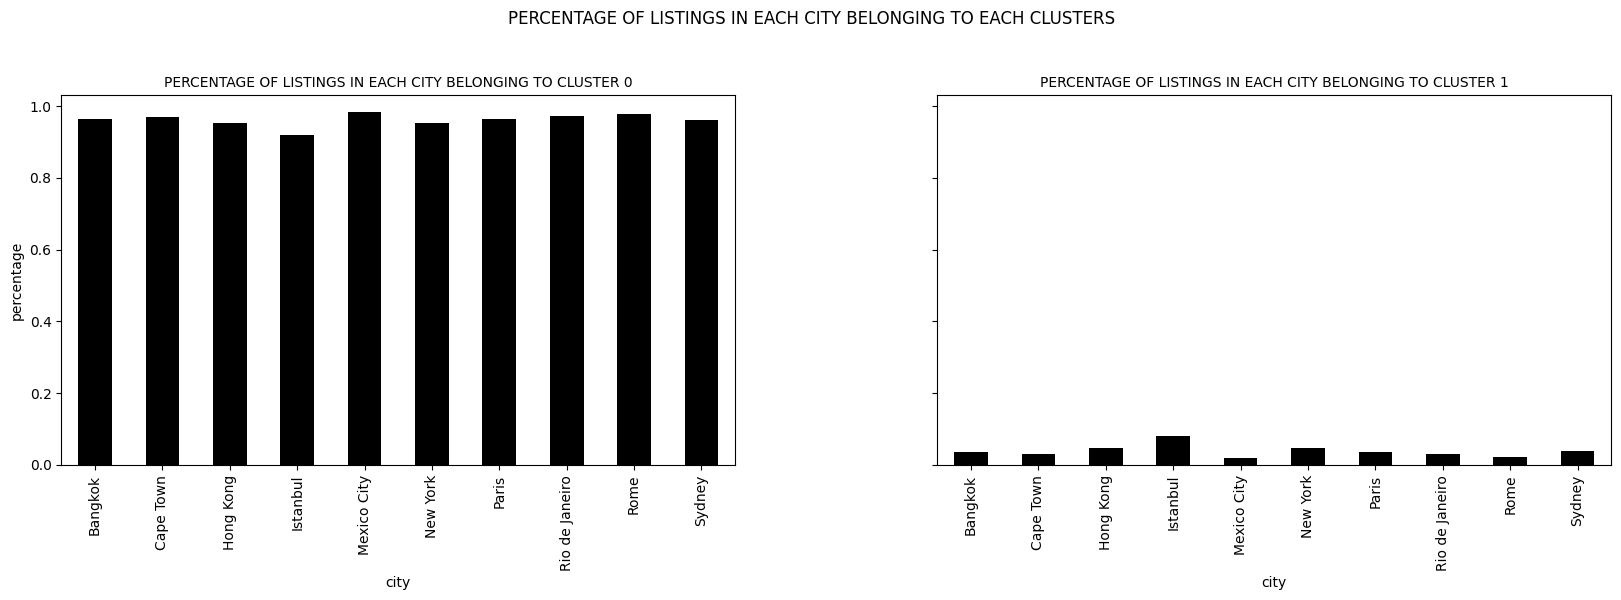

In [310]:
#@title CLUSTERS RES

cities = ORIGINAL_DF_KMEANS.reset_index()

all = cities['city'].value_counts()
cluster_0 = cities[cities['cluster'] == 0]['city'].value_counts()
cluster_1 = cities[cities['cluster'] == 1]['city'].value_counts()

data = {
    'all': all,
    'cluster_0': cluster_0,
    'cluster_1': cluster_1
}

merged_df = pd.DataFrame(data)

merged_df.reset_index(inplace=True)
merged_df.rename(columns={'index': 'city'}, inplace=True)
merged_df['relative_freq_cluster_0'] = merged_df['cluster_0'] / merged_df['all']
merged_df['relative_freq_cluster_1'] = merged_df['cluster_1'] / merged_df['all']
merged_df=merged_df.set_index('city')


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharey=True)  # Add sharey=True

plt.sca(axs[0])
merged_df['relative_freq_cluster_0'].plot(kind='bar', color='black')
plt.xlabel('city')
plt.ylabel('percentage')
plt.title('Percentage of Listings in Each City Belonging to Cluster 0'.upper(), fontsize=10)

plt.sca(axs[1])
merged_df['relative_freq_cluster_1'].plot(kind='bar', color='black')
plt.xlabel('city')
plt.ylabel('percentage')
plt.title('Percentage of Listings in Each City Belonging to Cluster 1'.upper(), fontsize=10)

fig.suptitle('Percentage of Listings in Each City Belonging to Each Clusters'.upper(), fontsize=12, y=1.02)
plt.subplots_adjust(top=0.85,hspace=0.5, wspace=0.3)  # Adjust the values as needed

In [311]:
ORIGINAL_DF_KMEANS['cluster'].value_counts().sort_index() # check amount of observations in each cluster

0    54370
1     2062
Name: cluster, dtype: int64

## DATASET PREPARATIONS

#### TRANSFORMATION

In [312]:
#@title PREPROCCES (2)

original_df_backup = ORIGINAL_DF.copy()

BINARY, GET_DUMMIES = ['host_is_superhost','host_identity_verified','instant_bookable','host_has_profile_pic'], ['city','room_type','stay_duration','host_response_time']

ORIGINAL_DF = pd.concat((pd.get_dummies(ORIGINAL_DF.loc[:,GET_DUMMIES]), ORIGINAL_DF.drop(columns=GET_DUMMIES)), axis=1).drop(columns=['city_Bangkok','room_type_Hotel room','stay_duration_Flexible','host_response_time_a few days or more'])

for feature in BINARY:
  ORIGINAL_DF[feature] = ORIGINAL_DF[feature].map({'t' : 1, 'f' : 0})

#### SPLITTING INTO TRAINING TEST AND VALIDATION SET

In [313]:
TARGET = 'price_log'

In [314]:
#@title PREPROCCES (2)
X_TRAIN, Y_TRAIN, X_TEST, Y_TEST = split_data(ORIGINAL_DF, TARGET, frac_test = 0.2, seed = 5)

In [315]:
#@title PREPROCCES (2)

val_size = X_TEST.shape[0]
X_VAL = X_TRAIN.sample(val_size, random_state=100)
v_inds = X_VAL.index
X_VAL = X_VAL.reset_index(drop=True)
Y_VAL = Y_TRAIN[v_inds]
X_TRAIN = X_TRAIN.drop(index=v_inds).reset_index(drop=True)
Y_TRAIN = np.delete(Y_TRAIN, v_inds)

In [316]:
#@title PREPROCCES (2)

print('number of points in the train set {} number of points in the test set {} number of points in the validation set {}'.format(X_TRAIN.shape[0], X_TEST.shape[0], X_VAL.shape[0]))

number of points in the train set 33858 number of points in the test set 11287 number of points in the validation set 11287


In [317]:
X_TRAIN.columns.tolist() == X_TEST.columns.tolist() == X_VAL.columns.tolist() # make sure that all categories are in all sets

True

#### TRANSFORMATION

In [318]:
#@title PREPROCCES (2)

x_train_backup = X_TRAIN.copy()
x_val_backup = X_VAL.copy()
x_test_backup = X_TEST.copy()

In [319]:
#@title PREPROCCES (2)

scaler_standard = StandardScaler()
scaler_standard = scaler_standard.fit(X_TRAIN)

# train

X_TRAIN = pd.DataFrame(scaler_standard.transform(X_TRAIN), columns = X_TRAIN.columns)

# validation

X_VAL = pd.DataFrame(scaler_standard.transform(X_VAL), columns = X_VAL.columns)

# test

X_TEST = pd.DataFrame(scaler_standard.transform(X_TEST), columns = X_VAL.columns)

#### DIMENSIONALITY REDUCTION





In [320]:
X_TRAIN.shape # we are indeed advisable to reduce dimensions...

(33858, 59)

In [321]:
from sklearn.feature_selection import SequentialFeatureSelector

In [322]:
#@title PREPROCCES (2)


def mean_squared_error_rounded(y_true, y_pred):
  return np.round(mean_squared_error(y_true, y_pred), 4)

mses_train = {}
mses_val = {}
features = {}

reg_tuning = LinearRegression(fit_intercept=True)
n_features_options = (8,12,15,20,28)

for n_features in n_features_options:
    sfs_forward = SequentialFeatureSelector(reg_tuning, n_features_to_select=n_features,
                                            direction="forward",
                                            scoring=make_scorer(mean_squared_error, greater_is_better=False))
    sfs_forward.fit(X_TRAIN, Y_TRAIN)
    reg_best = LinearRegression(fit_intercept=True).fit(X_TRAIN.loc[:, sfs_forward.get_support()], Y_TRAIN)
    features[n_features] = X_TRAIN.columns[sfs_forward.get_support()]
    mses_train[n_features] = mean_squared_error_rounded(Y_TRAIN, reg_best.predict(X_TRAIN.loc[:, sfs_forward.get_support()]))
    mses_val[n_features] = mean_squared_error_rounded(Y_VAL, reg_best.predict(X_VAL.loc[:, sfs_forward.get_support()]))

all_mses = pd.DataFrame(columns=['number_of_features','train_MSE','val_MSE'])
all_mses['number_of_features'] = features.keys()
all_mses['train_MSE'] = mses_train
all_mses['val_MSE'] = mses_val

<Axes: title={'center': 'Train and Validation mses by Different Number of Features'}, xlabel='Number of Features', ylabel='MSE'>

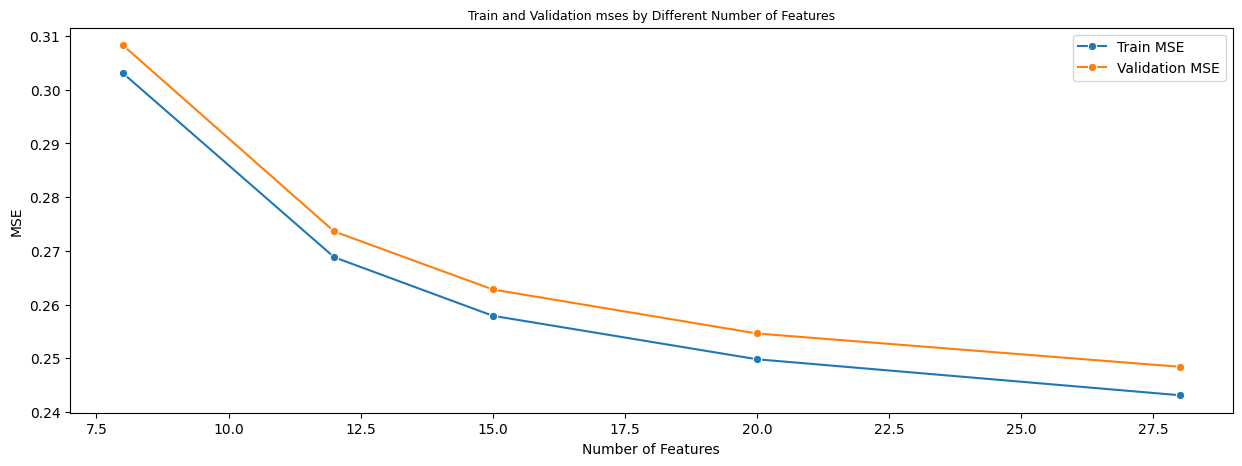

In [323]:
#@title PREPROCCES (2)

plt.figure(figsize=(15,5))
sns.lineplot(x=n_features_options, y=mses_train.values(), label='Train MSE', marker='o')
plt.xlabel('Number of Features')
plt.ylabel('MSE')
plt.title('Train and Validation mses by Different Number of Features', fontsize=9)
sns.lineplot(x=n_features_options, y=mses_val.values(), label='Validation MSE', marker='o')

In [324]:
best_num_features = 12

In [325]:
best_features = features[best_num_features]

In [326]:
#@title BEST FEATURES

X_TRAIN = X_TRAIN[best_features]
X_TEST = X_TEST[best_features]
X_VAL = X_VAL[best_features]

In [327]:
#@title CORRELATIONS

X_TRAIN[best_features].corr(method = 'pearson').style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-327-fed0c138176b>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  X_TRAIN[best_features].corr(method = 'pearson').style.background_gradient(cmap='coolwarm').set_precision(2)


,city_Cape Town,city_Hong Kong,city_Istanbul,city_New York,city_Paris,city_Rome,city_Sydney,room_type_Private room,room_type_Shared room,bedrooms,HEATING,num_amenities
city_Cape Town,1.00,-0.05,-0.11,-0.13,-0.13,-0.13,-0.11,-0.05,-0.03,0.14,-0.02,0.13
city_Hong Kong,-0.05,1.00,-0.04,-0.05,-0.05,-0.05,-0.04,0.06,0.01,-0.01,-0.08,-0.07
city_Istanbul,-0.11,-0.04,1.00,-0.12,-0.12,-0.13,-0.10,-0.06,-0.00,-0.04,0.21,0.05
city_New York,-0.13,-0.05,-0.12,1.00,-0.15,-0.15,-0.12,0.17,0.04,-0.06,0.26,0.10
city_Paris,-0.13,-0.05,-0.12,-0.15,1.00,-0.15,-0.13,-0.12,-0.01,-0.06,0.26,-0.05
city_Rome,-0.13,-0.05,-0.13,-0.15,-0.15,1.00,-0.13,-0.03,-0.02,0.00,0.26,0.02
city_Sydney,-0.11,-0.04,-0.10,-0.12,-0.13,-0.13,1.00,0.01,0.01,0.05,0.07,0.15
room_type_Private room,-0.05,0.06,-0.06,0.17,-0.12,-0.03,0.01,1.00,-0.05,-0.29,-0.07,-0.24
room_type_Shared room,-0.03,0.01,-0.00,0.04,-0.01,-0.02,0.01,-0.05,1.00,-0.06,-0.02,-0.06
bedrooms,0.14,-0.01,-0.04,-0.06,-0.06,0.00,0.05,-0.29,-0.06,1.00,0.00,0.25


## ALGORITHM


In [328]:
reg = LinearRegression(fit_intercept=True).fit(X_TRAIN, Y_TRAIN)

#### MODEL EVALUATION

In [329]:
#@title CODE (PART 1)

BASLINE = add_baseline(Y_TRAIN, Y_TEST)
BASLINE

{'model': 'baseline',
 'mse train': 0.71,
 'mse test': 0.723,
 'number of features': 0}

In [330]:
#@title CODE (PART 1)

add_model('LINEAR REGRESSION', reg, X_TRAIN, Y_TRAIN, X_TEST, Y_TEST)

{'model': 'LINEAR REGRESSION',
 'mse train': 0.269,
 'mse test': 0.269,
 'number of features': 12}

Beginning with the estimation of MSE was a valuable initial step as it enabled us to effectively compare models. To gain a more comprehensive understanding of model's performance we'll enhance our evaluation through incorporating additional indices including RMSE | MAE | $R^2$ as well as their CI.

In [331]:
#@title CODE (PART 1)

{'model': 'LINEAR REGRESSION',
          'rmse train': np.round(np.sqrt(mean_squared_error(Y_TRAIN, reg.predict(X_TRAIN))), 3),
          'rmse test': np.round(np.sqrt(mean_squared_error(Y_TEST, reg.predict(X_TEST))), 3),
          'number of features': X_TEST.shape[1]}

{'model': 'LINEAR REGRESSION',
 'rmse train': 0.518,
 'rmse test': 0.519,
 'number of features': 12}

In [332]:
#@title CODE (PART 1)

{'model': 'LINEAR REGRESSION',
          'mae train': np.round(mean_absolute_error(Y_TRAIN, reg.predict(X_TRAIN)), 3),
          'mae test': np.round(mean_absolute_error(Y_TEST, reg.predict(X_TEST)), 3),
          'number of features': X_TEST.shape[1]}

{'model': 'LINEAR REGRESSION',
 'mae train': 0.396,
 'mae test': 0.4,
 'number of features': 12}

In [333]:
#@title CODE (PART 1)

{'model': 'LINEAR REGRESSION',
          'explained variance train': np.round(r2_score(Y_TRAIN, reg.predict(X_TRAIN)), 3),
          'explained variance test': np.round(r2_score(Y_TEST, reg.predict(X_TEST)), 3),
          'number of features': X_TEST.shape[1]}

{'model': 'LINEAR REGRESSION',
 'explained variance train': 0.621,
 'explained variance test': 0.627,
 'number of features': 12}

Instead of comparing the test RMSE as a measure of generalization we would like to have a more trusted comparison. Therefore we bootstrap the test set (resample with replacements) and compare the average RMSE. In addition we'll estimate how spread is the distribution of possible RMSES by computing the SD as well as CI of the average RMSE.

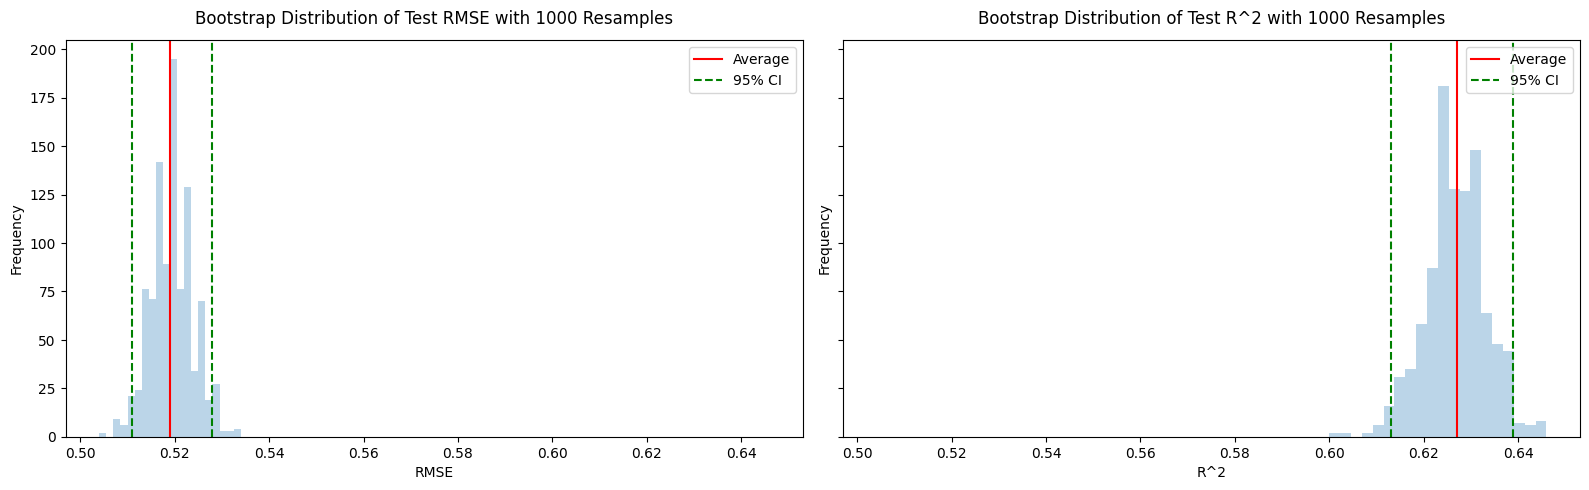

average RMSE: 0.5191910000000001 SD RMSE: 0.005 average R^2: 0.626737 SD R^2: 0.005


In [334]:
#@title CODE (PART 1)

RMSES = []
R = []

num_rep = 1000
test_size = X_TEST.shape[0]
for i in range(num_rep):
  np.random.seed(i + 1)
  inds = np.random.choice(test_size, test_size, replace=True)
  X_TEST_I = X_TEST.loc[inds,:]
  Y_TEST_I = Y_TEST[inds]
  mse = mean_squared_error(Y_TEST_I, reg.predict(X_TEST_I))
  RMSES.append(np.round(np.sqrt(mse), 3))
  R.append(np.round(r2_score(Y_TEST_I, reg.predict(X_TEST_I)), 3))

my_dict = {'RMSE' : RMSES, 'R^2' : R}

i = 0
fig, ax = plt.subplots(1,2,figsize = (16,5), sharex=True, sharey=True)
for k, v in my_dict.items():
  ax[i].hist(v, bins=20, alpha=0.3)
  avg = np.round(np.mean(v), 3)
  lower = np.percentile(v, 2.5)
  upper = np.percentile(v, 97.5)
  ax[i].set_title('Bootstrap Distribution of Test ' + k + ' with 1000 Resamples',y=1.02)
  ax[i].axvline(avg, c='r', ls='-', label="Average")
  ax[i].axvline(lower, c='g', ls='--', label="95% CI")
  ax[i].axvline(upper, c='g', ls='--')
  ax[i].set_xlabel(k)
  ax[i].set_ylabel('Frequency')
  ax[i].legend(loc='upper right')
  i += 1

plt.tight_layout()
plt.show()

print('average RMSE: {} SD RMSE: {} average R^2: {} SD R^2: {}'.format(np.mean(RMSES), np.std(RMSES).round(3), np.mean(R), np.std(RMSES).round(3)))

To evaluate the impact on the model's performance as a measure of uncertainty  we'll perform a **SENSITIVITY ANALYSIS** to assess the model stability to a noisy target and random data (we'll add noise and permuted the target).

In [335]:
#@title CODE (PART 1)
STD_TRAIN = round(np.std(Y_TRAIN, ddof=1), 2)
train_size = Y_TRAIN.size
TEST_MSE = mean_squared_error(Y_TEST, reg.predict(X_TEST))

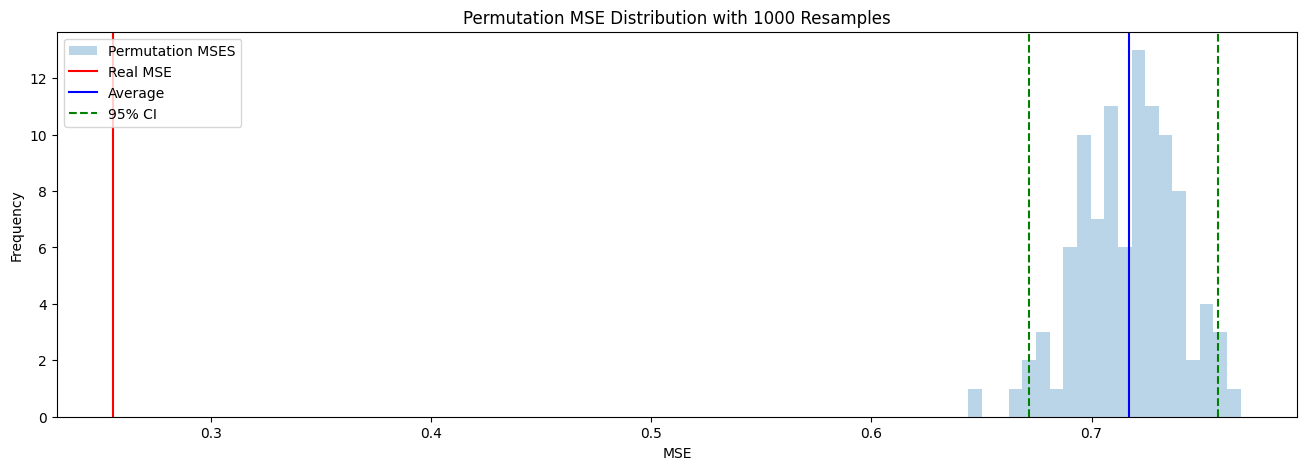

In [336]:
#@title CODE (PART 1)

import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(42)

# 10,000 datapoints
subset_size = 10000
random_indices = X_TRAIN.sample(subset_size, replace=False).index
X_subset = X_TRAIN.iloc[random_indices]
Y_subset = Y_TRAIN[random_indices]

# Calculate real MSE
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42)
model_real = LinearRegression(fit_intercept=True).fit(X_train_real, y_train_real)
preds_real = model_real.predict(X_test_real)
real_mse = mean_squared_error(y_test_real, preds_real)

# Permutation test or the resampling test.
permuted_mses = []
permutation_iters = 100
for i in range(permutation_iters):
    # Shuffle the indices to randomly assign the target labels to samples
    np.random.shuffle(Y_subset)
    # When we obtain train and test splits, the assignments are random.
    X_train, X_test, y_train, y_test = train_test_split(X_subset, Y_subset, test_size=0.2, random_state=42)
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    permuted_mses.append(mean_squared_error(y_test, preds))



# plot

fig, ax = plt.subplots(figsize=(16,5))
ax.hist(permuted_mses, bins=20, alpha=0.3, label="Permutation MSES")
ax.axvline(real_mse, c='r', ls='-', label="Real MSE")
avg = np.round(np.mean(permuted_mses), 3)
lower = np.percentile(permuted_mses, 2.5)
upper = np.percentile(permuted_mses, 97.5)
ax.axvline(avg, c='b', ls='-', label="Average")
ax.axvline(lower, c='g', ls='--', label="95% CI")
ax.axvline(upper, c='g', ls='--')
ax.set_title("Permutation MSE Distribution with 1000 Resamples")
ax.set_xlabel('MSE')
ax.set_ylabel('Frequency')
ax.legend(loc='upper left')
plt.show()

In [337]:
#@title CODE (PART 1)
print('STD train {}'.format(STD_TRAIN))

STD train 0.84


Text(0.5, 1.0, 'MSES by adding different levels of noise to the target variable')

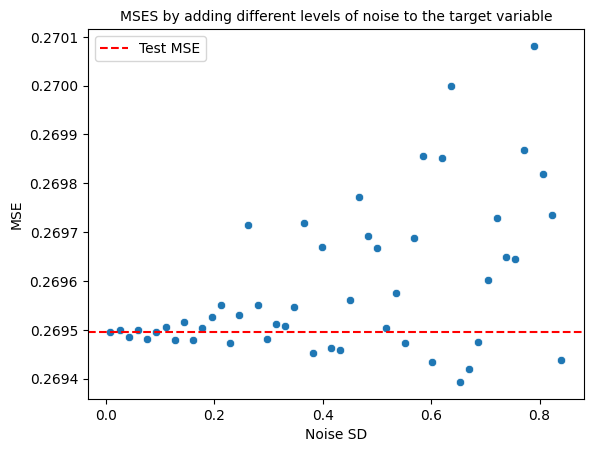

In [338]:
#@title CODE (PART 1)

sigmas = np.linspace(STD_TRAIN / 100, STD_TRAIN, 50)
all_mses = []
for sigma in sigmas:
  Y_train_noise = Y_TRAIN.copy() + np.random.normal(loc=0, scale=sigma, size=train_size)
  lr_model = LinearRegression(fit_intercept=True).fit(X_TRAIN, Y_train_noise)
  all_mses.append(mean_squared_error(Y_TEST, lr_model.predict(X_TEST)))

fig, ax = plt.subplots()
ax.axhline(TEST_MSE, label='Test MSE', c='r', ls='--')
sns.scatterplot(x=sigmas, y=all_mses, ax=ax)
ax.set_xlabel('Noise SD')
ax.set_ylabel('MSE')
ax.set_title('MSES by adding different levels of noise to the target variable', fontsize=10)

#### IMPORTANCE (VARS)

In [351]:
coefs = {}
for i, fearure in enumerate(X_TRAIN.columns):
   coefs[fearure] = round(reg.coef_[i], 3)
coefs['intercept'] = round(reg.intercept_, 3)

{'city_Cape Town': 0.119,
 'city_Hong Kong': 0.104,
 'city_Istanbul': -0.073,
 'city_New York': 0.319,
 'city_Paris': 0.249,
 'city_Rome': 0.204,
 'city_Sydney': 0.249,
 'room_type_Private room': -0.211,
 'room_type_Shared room': -0.092,
 'bedrooms': 0.335,
 'HEATING': 0.015,
 'num_amenities': 0.136,
 'intercept': 4.101}

In [340]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=99a14505d43920d45d8555a92940a9b8c035c452a5c41aad441c95c7185a14ff
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [341]:
#@title CODE (PART 2)

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(reg, random_state=1).fit(X_VAL, Y_VAL)
eli5.show_weights(perm, feature_names = X_VAL.columns.tolist())

Weight,Feature
0.3148 ± 0.0091,bedrooms
0.2807 ± 0.0103,city_New York
0.1707 ± 0.0079,city_Sydney
0.1609 ± 0.0043,city_Paris
0.1240 ± 0.0048,city_Rome
0.1206 ± 0.0088,room_type_Private room
0.0503 ± 0.0029,num_amenities
0.0378 ± 0.0022,city_Cape Town
0.0264 ± 0.0019,room_type_Shared room
0.0246 ± 0.0029,city_Hong Kong


#### ERROR ANALYSIS (1)

shifting our attention to conducting an **ERROR ANALYSIS** we will begin in creating a plot that provides us with insights into the model's errors made.

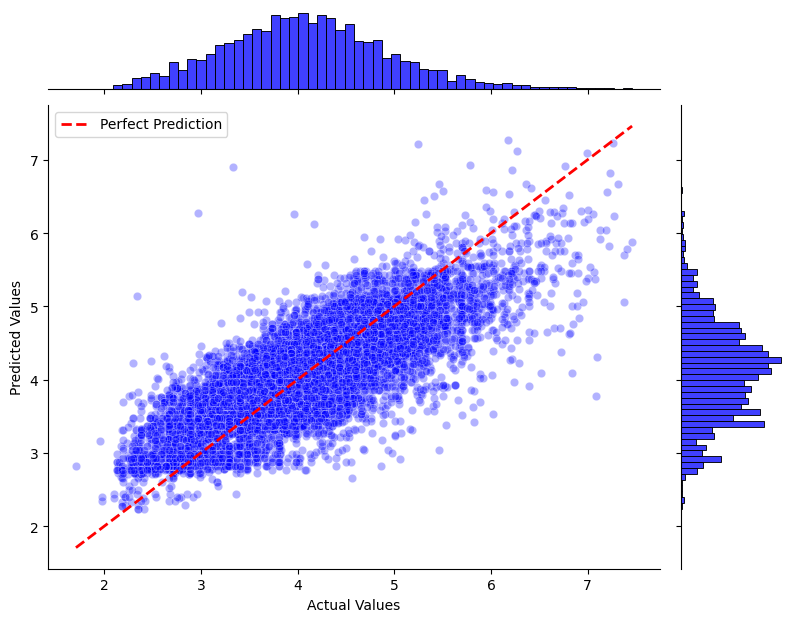

In [342]:
#@title CODE (PART 3)

grid = sns.jointplot(x=Y_TEST, y=reg.predict(X_TEST), kind='scatter', color='Blue', alpha=0.3, height=8)
grid.figure.set_size_inches(8,6)
plt.plot([min(Y_TEST), max(Y_TEST)], [min(Y_TEST), max(Y_TEST)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

Our challenges might be tied to DIMANSIONALITY REDUCTION technique which is **not** a straightforward process and lacks a universal solution.

In [343]:
#@title CODE (PART 3)

df_cor = ORIGINAL_DF.drop(columns='price_log')
corr_with_target = df_cor.corrwith(ORIGINAL_DF['price_log'], method='pearson').round(3).reset_index().rename(columns = {'index' : 'feature', 0 : 'correlation_with_target'}).sort_values(by = 'correlation_with_target', ascending = False).reset_index(drop=True)
best_features_cor = list(corr_with_target.loc[corr_with_target['correlation_with_target'] > 0.1, :]['feature'].values)

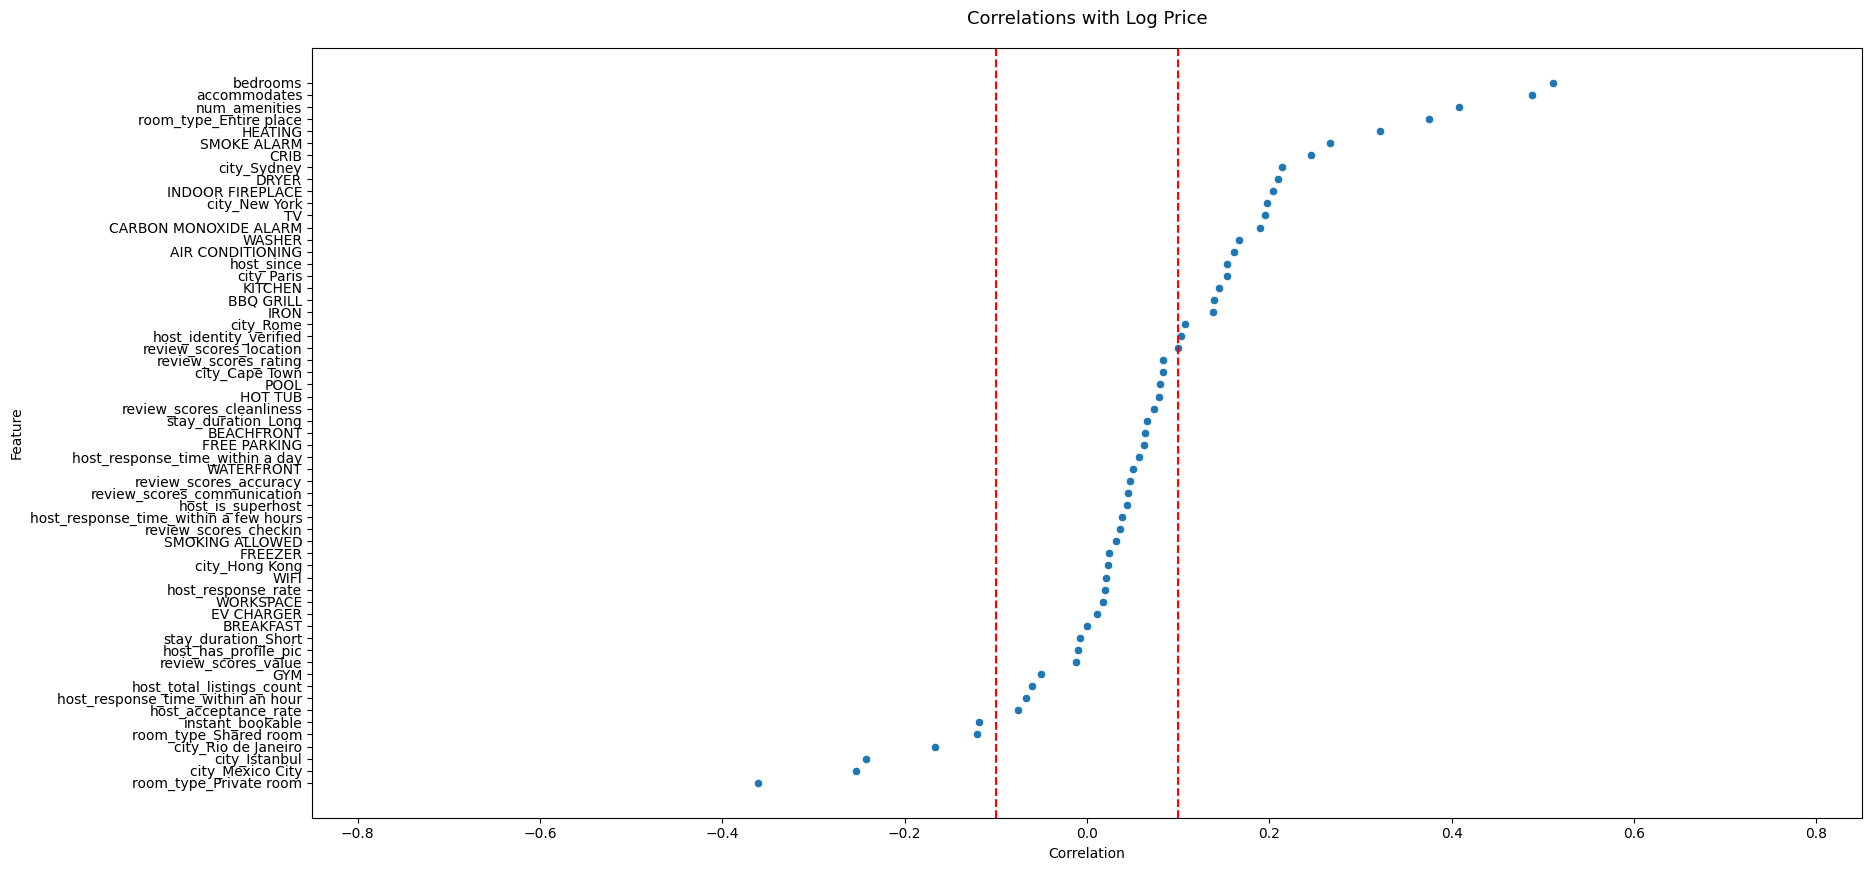

In [344]:
#@title CODE (PART 3)

fig, ax = plt.subplots(figsize=(20,10))
sns.scatterplot(data=corr_with_target, x='correlation_with_target', y='feature', ax=ax)
ax.axvline(x=0.1, color='r', linestyle='--')
ax.axvline(x=-0.1, color='r', linestyle='--')
ax.set_yticks(corr_with_target.index)
ax.set_xlim(-0.85,0.85)
ax.set_xlabel('Correlation')
ax.set_ylabel('Feature')
ax.set_title('Correlations with Log Price', y=1.02, fontsize=13)
plt.show()

In [345]:
THRESHOLD = 0.1

In [346]:
new_features = set(best_features_cor) | set(best_features) # taking the features that came out with the two techniques

In [347]:
#@title CODE (PART 3)

x_train_backup = x_train_backup[new_features]
x_val_backup = x_val_backup[new_features]
x_test_backup = x_test_backup[new_features]

<ipython-input-347-18ee9e7922b6>:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_train_backup = x_train_backup[new_features]
<ipython-input-347-18ee9e7922b6>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_val_backup = x_val_backup[new_features]
<ipython-input-347-18ee9e7922b6>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x_test_backup = x_test_backup[new_features]


In [348]:
reg_new = LinearRegression(fit_intercept=True).fit(x_train_backup, Y_TRAIN)

In [349]:
#@title CODE (PART 3)

{'model' : 'LR with more features',
            'mse train': np.round(mean_squared_error(Y_TRAIN, reg_new.predict(x_train_backup)), 3),
            'mse validation': np.round(mean_squared_error(Y_VAL, reg_new.predict(x_val_backup)), 3),
            'mse test': np.round(mean_squared_error(Y_TEST, reg_new.predict(x_test_backup)), 3),
            'number of features': x_train_backup.shape[1]}

{'model': 'LR with more features',
 'mse train': 0.255,
 'mse validation': 0.259,
 'mse test': 0.256,
 'number of features': 27}

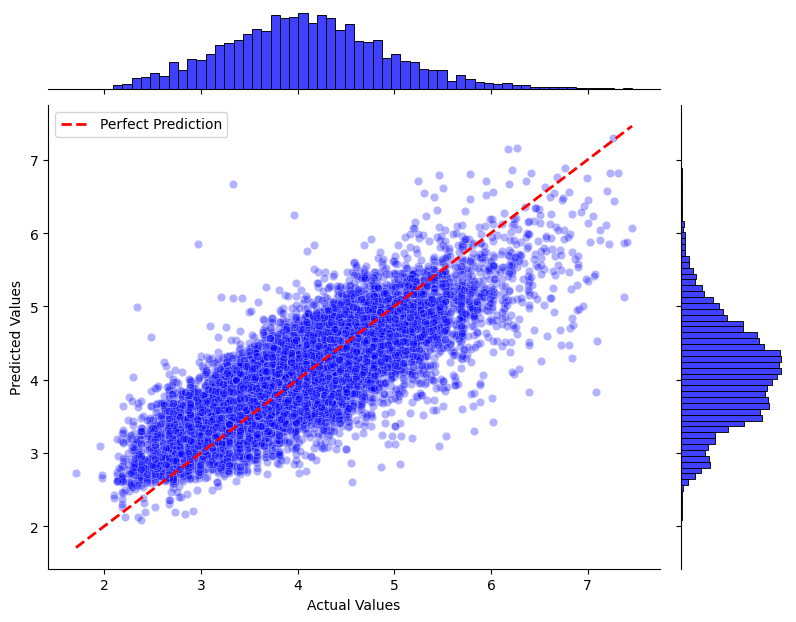

In [350]:
#@title CODE (PART 3)

grid = sns.jointplot(x=Y_TEST, y=reg_new.predict(x_test_backup), kind='scatter', color='Blue', alpha=0.3, height=8)
grid.figure.set_size_inches(8,6)
plt.plot([min(Y_TEST), max(Y_TEST)], [min(Y_TEST), max(Y_TEST)], linestyle='--', color='red', linewidth=2, label='Perfect Prediction')
plt.legend()
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()